# Сборный проект - анализ данных о компьютерных играх

**Задачи исследования:** 
- выявить определяющие успешность игры закономерности
- определить для пользователя каждого региона самые популярные платформы, самые популярные жанры, и влияние рейтинга ESRB на продажи в отдельном регионе
- сравнить пользовательские рейтинги платформ Xbox One и PC
- сравнить пользовательские рейтинги жанров Action и Sports

In [1]:
!pip install pandas==1.5.3 -q

import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from scipy import stats as st
import os
import platform

## Шаг 1. Загрузка данных

Прочитаем данные об играх из файла

In [2]:
datasets_path='/datasets/'
if platform.system()=='Windows':
    cwd = os.getcwd()
    datasets_path= os.getcwd()+'\\datasets\\'
games_data= pd.read_csv(datasets_path+'games.csv')

Выведем первые 10 строк чтоб убедиться, что данные загружены

In [3]:
games_data.head(10)

,Name,Platform,Year_of_Release,Genre,NA_sales,EU_sales,JP_sales,Other_sales,Critic_Score,User_Score,Rating
0,Wii Sports,Wii,2006.0,Sports,41.36,28.96,3.77,8.45,76.0,8,E
1,Super Mario Bros.,NES,1985.0,Platform,29.08,3.58,6.81,0.77,NaN,NaN,NaN
2,Mario Kart Wii,Wii,2008.0,Racing,15.68,12.76,3.79,3.29,82.0,8.3,E
3,Wii Sports Resort,Wii,2009.0,Sports,15.61,10.93,3.28,2.95,80.0,8,E
4,Pokemon Red/Pokemon Blue,GB,1996.0,Role-Playing,11.27,8.89,10.22,1.00,NaN,NaN,NaN
5,Tetris,GB,1989.0,Puzzle,23.20,2.26,4.22,0.58,NaN,NaN,NaN
6,New Super Mario Bros.,DS,2006.0,Platform,11.28,9.14,6.50,2.88,89.0,8.5,E
7,Wii Play,Wii,2006.0,Misc,13.96,9.18,2.93,2.84,58.0,6.6,E
8,New Super Mario Bros. Wii,Wii,2009.0,Platform,14.44,6.94,4.70,2.24,87.0,8.4,E
9,Duck Hunt,NES,1984.0,Shooter,26.93,0.63,0.28,0.47,NaN,NaN,NaN


## Шаг 2. Подготовка данных

### Замена названий столбцов

Изучение данных об играх - столбцы и типы

In [4]:
games_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16715 entries, 0 to 16714
Data columns (total 11 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Name             16713 non-null  object 
 1   Platform         16715 non-null  object 
 2   Year_of_Release  16446 non-null  float64
 3   Genre            16713 non-null  object 
 4   NA_sales         16715 non-null  float64
 5   EU_sales         16715 non-null  float64
 6   JP_sales         16715 non-null  float64
 7   Other_sales      16715 non-null  float64
 8   Critic_Score     8137 non-null   float64
 9   User_Score       10014 non-null  object 
 10  Rating           9949 non-null   object 
dtypes: float64(6), object(5)
memory usage: 1.4+ MB


Приведем наименования столбцов к нижнему регистру

In [5]:
games_data.columns = map(str.lower, games_data.columns)
games_data.columns

Index(['name', 'platform', 'year_of_release', 'genre', 'na_sales', 'eu_sales',
       'jp_sales', 'other_sales', 'critic_score', 'user_score', 'rating'],
      dtype='object')

### Обработка пропусков и замена типов

Проанализируем количество пропусков в данных по столбцам

In [6]:
games_data.isna().sum()

name                  2
platform              0
year_of_release     269
genre                 2
na_sales              0
eu_sales              0
jp_sales              0
other_sales           0
critic_score       8578
user_score         6701
rating             6766
dtype: int64

Проанализируем, какой процент пропусков в данных по столбцам

In [7]:
pd.DataFrame(round(games_data.isna().mean()*100,1)).style.background_gradient('coolwarm')

,0
name,0.000000
platform,0.000000
year_of_release,1.600000
genre,0.000000
na_sales,0.000000
eu_sales,0.000000
jp_sales,0.000000
other_sales,0.000000
critic_score,51.300000
user_score,40.100000


Удалим данные с пропусками для наименования игры, года выпуска и жанра тк доля этих данных невелика (менее 2%)

In [8]:
games_data= games_data.dropna(subset=['name', 'year_of_release', 'genre'])
games_data.isna().sum()

name                  0
platform              0
year_of_release       0
genre                 0
na_sales              0
eu_sales              0
jp_sales              0
other_sales           0
critic_score       8461
user_score         6605
rating             6676
dtype: int64

Заменим год выпуска на "целое" тк для года (не даты) это кажется оптимальным выбором для дальнейшей обработки

In [9]:
games_data['year_of_release'] = games_data['year_of_release'].astype('int64',  errors='ignore')
games_data.head(10)

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating
0,Wii Sports,Wii,2006,Sports,41.36,28.96,3.77,8.45,76.0,8,E
1,Super Mario Bros.,NES,1985,Platform,29.08,3.58,6.81,0.77,NaN,NaN,NaN
2,Mario Kart Wii,Wii,2008,Racing,15.68,12.76,3.79,3.29,82.0,8.3,E
3,Wii Sports Resort,Wii,2009,Sports,15.61,10.93,3.28,2.95,80.0,8,E
4,Pokemon Red/Pokemon Blue,GB,1996,Role-Playing,11.27,8.89,10.22,1.00,NaN,NaN,NaN
5,Tetris,GB,1989,Puzzle,23.20,2.26,4.22,0.58,NaN,NaN,NaN
6,New Super Mario Bros.,DS,2006,Platform,11.28,9.14,6.50,2.88,89.0,8.5,E
7,Wii Play,Wii,2006,Misc,13.96,9.18,2.93,2.84,58.0,6.6,E
8,New Super Mario Bros. Wii,Wii,2009,Platform,14.44,6.94,4.70,2.24,87.0,8.4,E
9,Duck Hunt,NES,1984,Shooter,26.93,0.63,0.28,0.47,NaN,NaN,NaN


Проверка гипотезы, что пропуски в данных об оценках и рейтинге обусловлены слабым развитием интернет до определенного момента (а позже составлялись как раз в интернет)

In [10]:
print('Количество оценок критиков до 1996 года:', games_data[games_data['year_of_release']<1996]['critic_score'].count())
print('Количество оценок пользователей до 1996 года:', games_data[games_data['year_of_release']<1996]['user_score'].count())
print('Количество рейтингов до 1996 года:', games_data[games_data['year_of_release']<1996]['rating'].count())

Количество оценок критиков до 1996 года: 4
Количество оценок пользователей до 1996 года: 4
Количество рейтингов до 1996 года: 5


In [11]:
print('Доля пропусков для оценок критиков до 1996 года от общего количества пропусков:', games_data[games_data['year_of_release']<1996]['critic_score'].isna().sum()/games_data['critic_score'].isna().sum())
print('Доля пропусков для оценок пользователей до 1996 года от общего количества пропусков:', games_data[games_data['year_of_release']<1996]['critic_score'].isna().sum()/games_data['user_score'].isna().sum())
print('Доля пропусков рейтингов до 1996 года от общего количества пропусков:', games_data[games_data['year_of_release']<1996]['rating'].isna().sum()/games_data['rating'].isna().sum())

Доля пропусков для оценок критиков до 1996 года от общего количества пропусков: 0.08285072686443683
Доля пропусков для оценок пользователей до 1996 года от общего количества пропусков: 0.10613171839515519
Доля пропусков рейтингов до 1996 года от общего количества пропусков: 0.1048532055122828


#### Обработка значения "tbd" для рейтинга пользователей

Значение "tbd" для оценок пользователей 

In [12]:
games_data['user_score'] = games_data['user_score'].apply(pd.to_numeric, errors='coerce')
games_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 16444 entries, 0 to 16714
Data columns (total 11 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   name             16444 non-null  object 
 1   platform         16444 non-null  object 
 2   year_of_release  16444 non-null  int64  
 3   genre            16444 non-null  object 
 4   na_sales         16444 non-null  float64
 5   eu_sales         16444 non-null  float64
 6   jp_sales         16444 non-null  float64
 7   other_sales      16444 non-null  float64
 8   critic_score     7983 non-null   float64
 9   user_score       7463 non-null   float64
 10  rating           9768 non-null   object 
dtypes: float64(6), int64(1), object(4)
memory usage: 1.5+ MB


In [13]:
100*games_data[games_data['user_score']=='tbd']['user_score'].count()/games_data['user_score'].count()

0.0

Преобразуем оценки пользователей в числа с плавающей точкой, при этом 'tbd' будет заменено на NaN (что правильно тк в дальнейшем не будет мешать анализу)

Значение "na" для оценок пользователей после преобразования в число

In [14]:
100*games_data['user_score'].isna().sum()/len(games_data['user_score'])

54.61566528825104

Посчитаем пропусков в данных для оценок критиков для сравнения

In [15]:
100*games_data['critic_score'].isna().sum()/len(games_data['critic_score'])

51.453417659936754

Сделаем заглушку для игр без рейтингов на 'Not specified' ('не указан'). С большой вероятностью рейтинга нет для игр, которые не продавались в Северной Америке, тк возрастной рейтинг обязателен только там.

In [16]:
games_data['rating']= games_data['rating'].fillna('Not specified')
games_data.isna().sum()

name                  0
platform              0
year_of_release       0
genre                 0
na_sales              0
eu_sales              0
jp_sales              0
other_sales           0
critic_score       8461
user_score         8981
rating                0
dtype: int64

### Проверка и обработка дубликатов

Поиск явных дубликатов

In [17]:
games_data.duplicated().sum()

0

**Вывод по явным дубликатам: явные дубликаты не обнаружены**

Сортированный список для поиска неявных дубликатов для наименований игр

In [18]:
game_names= sorted(games_data['name'].unique())
game_names[0:30]

[' Beyblade Burst',
 ' Fire Emblem Fates',
 " Frozen: Olaf's Quest",
 ' Haikyu!! Cross Team Match!',
 ' Tales of Xillia 2',
 "'98 Koshien",
 '.hack//G.U. Vol.1//Rebirth',
 '.hack//G.U. Vol.2//Reminisce',
 '.hack//G.U. Vol.2//Reminisce (jp sales)',
 '.hack//G.U. Vol.3//Redemption',
 '.hack//Infection Part 1',
 '.hack//Link',
 '.hack//Mutation Part 2',
 '.hack//Outbreak Part 3',
 '.hack//Quarantine Part 4: The Final Chapter',
 '.hack: Sekai no Mukou ni + Versus',
 '007 Racing',
 '007: Quantum of Solace',
 '007: The World is not Enough',
 '007: Tomorrow Never Dies',
 '1 vs. 100',
 '1/2 Summer +',
 '10 Minute Solution',
 '100 All-Time Favorites',
 '100 Classic Books',
 '100 Classic Games',
 '1000 Cooking Recipes from ELLE à table',
 '1001 Touch Games',
 '101-in-1 Explosive Megamix',
 '101-in-1 Party Megamix Wii']

Уберем пробелы в начале строки для первых записей в списке наименований игр

In [19]:
games_data['name']= games_data['name'].replace(' Beyblade Burst','Beyblade Burst')
games_data['name']= games_data['name'].replace(' Fire Emblem Fates','Fire Emblem Fates')
games_data['name']= games_data['name'].replace(" Frozen: Olaf's Quest","Frozen: Olaf's Quest")
games_data['name']= games_data['name'].replace(' Haikyu!! Cross Team Match!','Haikyu!! Cross Team Match!')
games_data['name']= games_data['name'].replace(' Tales of Xillia 2','Tales of Xillia 2')
game_names= sorted(games_data['name'].unique())[0:30]

Сортированный список для поиска неявных дубликатов для жанров игр

In [20]:
sorted(games_data['genre'].unique())

['Action',
 'Adventure',
 'Fighting',
 'Misc',
 'Platform',
 'Puzzle',
 'Racing',
 'Role-Playing',
 'Shooter',
 'Simulation',
 'Sports',
 'Strategy']

Сортированный список для поиска неявных дубликатов для платформ

In [21]:
sorted(games_data['platform'].unique())

['2600',
 '3DO',
 '3DS',
 'DC',
 'DS',
 'GB',
 'GBA',
 'GC',
 'GEN',
 'GG',
 'N64',
 'NES',
 'NG',
 'PC',
 'PCFX',
 'PS',
 'PS2',
 'PS3',
 'PS4',
 'PSP',
 'PSV',
 'SAT',
 'SCD',
 'SNES',
 'TG16',
 'WS',
 'Wii',
 'WiiU',
 'X360',
 'XB',
 'XOne']

Сортированный список для поиска неявных дубликатов для рейтинга

In [22]:
sorted(games_data['rating'].dropna().unique())

['AO', 'E', 'E10+', 'EC', 'K-A', 'M', 'Not specified', 'RP', 'T']

Проверим наличие неявных дубликатов для "составного ключа" датасета (имя игры, платформа и год релиза)

In [23]:
duplicated_games_data=games_data[games_data.duplicated(subset=['name', 'platform', 'year_of_release'], keep=False)]
duplicated_games_data

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating
604,Madden NFL 13,PS3,2012,Sports,2.11,0.22,0.0,0.23,83.0,5.5,E
16230,Madden NFL 13,PS3,2012,Sports,0.00,0.01,0.0,0.00,83.0,5.5,E


Просуммируем значения в первой строке перед удалением второй из дублированных 

In [24]:
games_data.loc[duplicated_games_data.head(1).index, 'eu_sales']=duplicated_games_data['eu_sales'].sum()
games_data.loc[duplicated_games_data.head(1).index]

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating
604,Madden NFL 13,PS3,2012,Sports,2.11,0.23,0.0,0.23,83.0,5.5,E


Удалим неявные дубликаты для сочетания "наименование игры, платформа, год выпуска"

In [25]:
games_data= games_data.drop_duplicates(subset=['name', 'platform', 'year_of_release'], keep='first')
games_data[games_data.duplicated(subset=['name', 'platform', 'year_of_release'], keep=False)]

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating


### Расчет суммарных продаж

In [67]:
games_data.loc[:, 'summary_sales']=games_data['na_sales']+games_data['eu_sales']+games_data['jp_sales']+games_data['other_sales']
games_data.head(10)

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating,summary_sales
0,Wii Sports,Wii,2006,Sports,41.36,28.96,3.77,8.45,76.0,8.0,E,82.54
1,Super Mario Bros.,NES,1985,Platform,29.08,3.58,6.81,0.77,NaN,NaN,Not specified,40.24
2,Mario Kart Wii,Wii,2008,Racing,15.68,12.76,3.79,3.29,82.0,8.3,E,35.52
3,Wii Sports Resort,Wii,2009,Sports,15.61,10.93,3.28,2.95,80.0,8.0,E,32.77
4,Pokemon Red/Pokemon Blue,GB,1996,Role-Playing,11.27,8.89,10.22,1.00,NaN,NaN,Not specified,31.38
5,Tetris,GB,1989,Puzzle,23.20,2.26,4.22,0.58,NaN,NaN,Not specified,30.26
6,New Super Mario Bros.,DS,2006,Platform,11.28,9.14,6.50,2.88,89.0,8.5,E,29.80
7,Wii Play,Wii,2006,Misc,13.96,9.18,2.93,2.84,58.0,6.6,E,28.91
8,New Super Mario Bros. Wii,Wii,2009,Platform,14.44,6.94,4.70,2.24,87.0,8.4,E,28.32
9,Duck Hunt,NES,1984,Shooter,26.93,0.63,0.28,0.47,NaN,NaN,Not specified,28.31


<b><u>Выводы по разделу "предобработка данных"<u><b>

<b>Вывод по наличию и обработке пропусков:</b>
<b><p> Для года выпуска игры, жанра и наименования пропуски в данных были минимальны, потому можно было их удалить без значительного влияния на последующий анализ.</p></b>
<b><p> Для года выпуска заменен тип на "целое", для оценок пользователей заменен тип на "число с плавающей точкой"</b></p> 
<b><p> Для оценки критиков, пользователей и рейтинга доля пропусков в данных значительная, и обусловлена она скорее всего тем, что данных о продажах и данные об отзывах берутся из разных источников (предположение о том, что все пропуски обусловлены более ранним периодом не подтвердилось).</b></p> 
<b><p> Пропуски в рейтинге скорее всего обусловлены тем, что он присваивался только для игр, продававшихся в Северной Америке. Поэтому чтоб не терять эту часть данных, ставим для пропущенных значений рейтинга заглушку "не указан" ('Not specified')</b></p> 
<b><p> Значение "tbd" в данных по моему опыту является "рукотворным" аналогом "NAN" ("tbd" зачастую проставляется пользователем, который не определился с значением). Это значение заменено на NaN при преобразовании оценок пользователей в число.
<b><p> Природа пропусков в оценке пользователей, критиков случайна, поэтому нельзя безболезненно заполнить пропуски каким-либо усредненным значением.</p></b>

**Вывод по обработке неявных дубликатов: неявных дубликатов для жанра игр не обнаружено. 
Для наименований игр выполнены удаления ведущих пробелов, для сочетания "имя игры/платформа/год выпуска" найдены и удалены неявные дубликаты. Для оценок пользователей дубликатов не выявлено.**

## Шаг 3. Исследовательский анализ данных

### Суммарный выпуск игр в разные годы

Визуализируем данные о продажах в разные годы для разных платформ

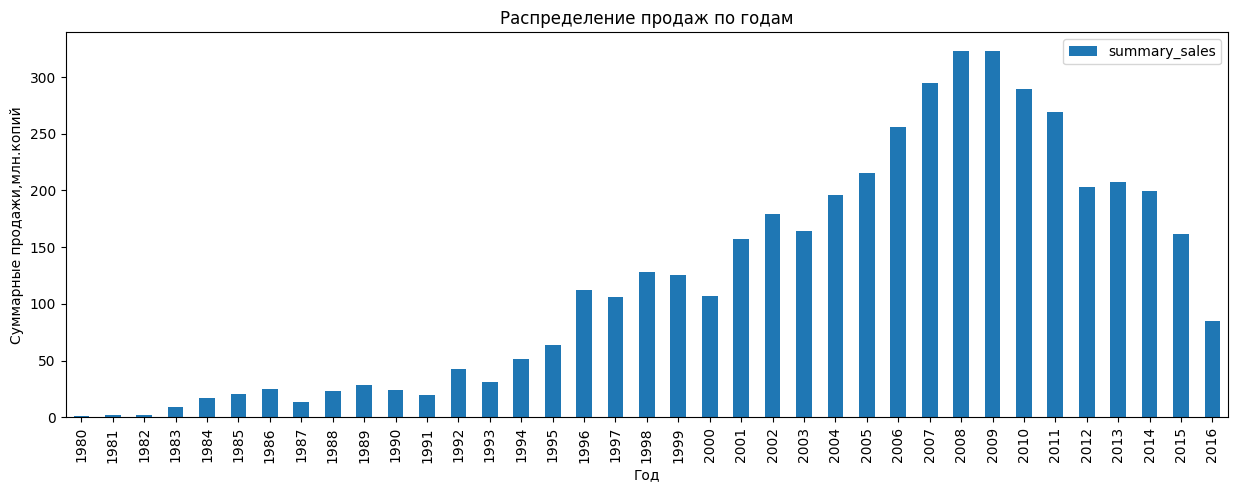

In [27]:
games_data.pivot_table(index='year_of_release', values='summary_sales', aggfunc='sum').plot(
figsize=(15,5),
kind='bar',
xlabel='Год',
ylabel='Суммарные продажи,млн.копий',
title='Распределение продаж по годам')
plt.show()

Оценим суммарные продажи до 1996 года

In [28]:
100*games_data[games_data['year_of_release']<1996]['year_of_release'].sum()/games_data['year_of_release'].sum()

4.254256887776937

**Вывод по распределению продаж по годам: данные по продажам до 1996 года составляют в сумме менее 5%, так что для составления прогнозов можно отсечь левый хвост распределения и пользоваться периодом с 1996 года до 2016 года (то есть не все периоды важны). Наибольшие продажи были в 2008 году, до этого был постепенный рост, позже - снижение продаж.**

### Анализ продаж по платформам

Визуализируем данные о суммарных продажах для различных платформ

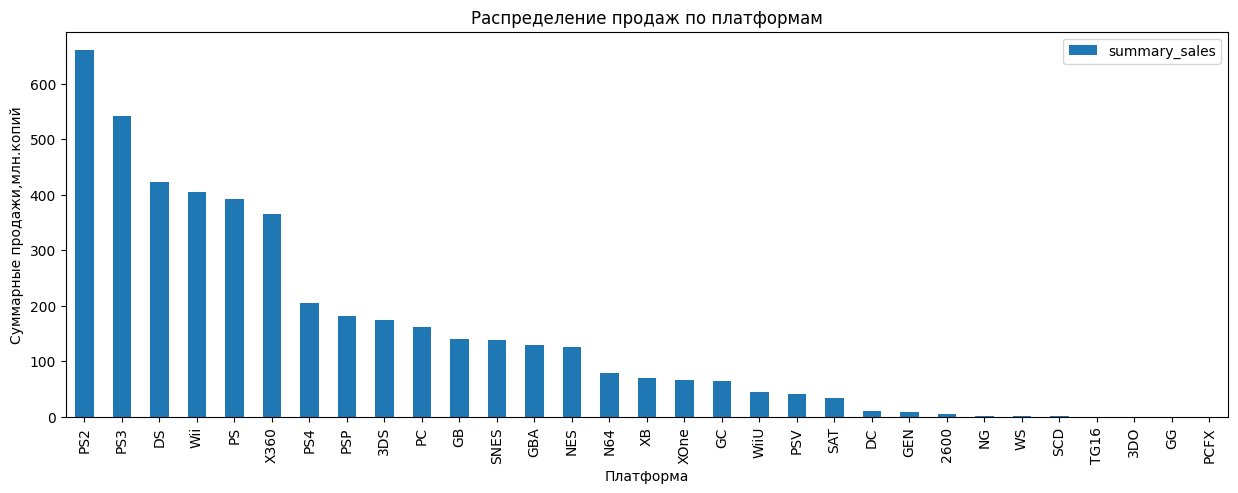

In [29]:
games_data_top= games_data.pivot_table(index=['platform'], values=['summary_sales'], aggfunc='sum').sort_values('summary_sales', ascending= False)
games_data_top.plot(
figsize=(15,5),
kind='bar',
xlabel='Платформа',
ylabel='Суммарные продажи,млн.копий',
title='Распределение продаж по платформам')
plt.show()

Визуализируем данные о продажах в разные годы для top-5 платформ (по объему продаж)

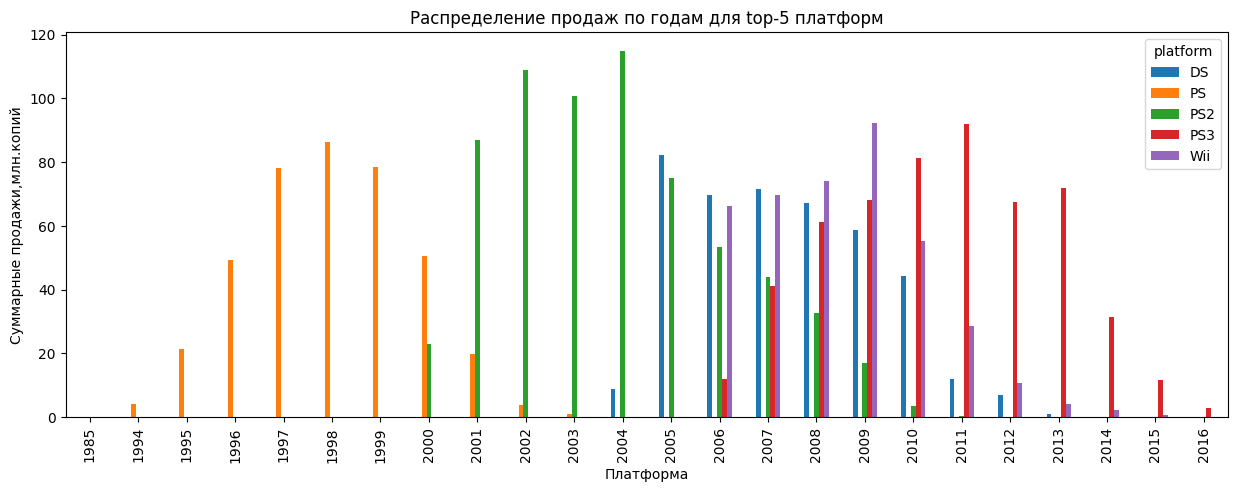

In [30]:
games_data[games_data['platform'].isin(games_data_top.head(5).index)].pivot_table(index=['year_of_release'], columns='platform', values='summary_sales', aggfunc='sum')\
.plot(
figsize=(15,5),
kind='bar',
xlabel='Платформа',
ylabel='Суммарные продажи,млн.копий',
title='Распределение продаж по годам для top-5 платформ')
plt.show()

Визуализация жизненного цикла платформы (длительность продаж)

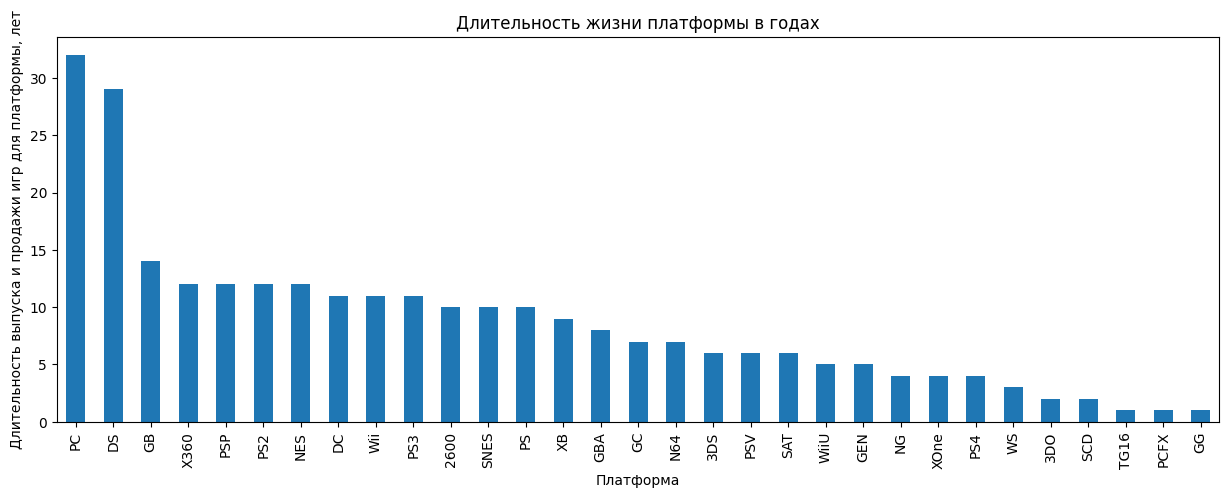

In [31]:
platform_lifetime= games_data[games_data['summary_sales']>0].groupby('platform')['year_of_release'].apply(lambda g: g.max()-g.min()+1).sort_values(ascending= False)
platform_lifetime.plot(
figsize=(15,5),
kind='bar',
xlabel='Платформа',
ylabel='Длительность выпуска и продажи игр для платформы, лет',
title='Длительность жизни платформы в годах')
plt.show()

In [32]:
#оценка разброса длительности жизни платформы
platform_lifetime.describe()

count    31.000000
mean      8.612903
std       6.998464
min       1.000000
25%       4.000000
50%       7.000000
75%      11.000000
max      32.000000
Name: year_of_release, dtype: float64

**Вывод: платформы с наибольшими продажами: 'PS2','X360', 'PS3', 'Wii', 'DS'. Суммарные продажи по платформам распределены  аналогично нормальному закону распределения. Новые платформы появляются, "набирают обороты" (продажи) и исчезают в среднем (по медиане) в течение 7 лет, хотя для отдельных платформ этот показатель выше, скорее всего так как PC (персональный компьютер) - не чисто игровая платформа, а DS и GB - портативные платформы с изначально достаточно простыми играми типа "Тетрис" (со своими "нестареющими" фанатами).**

### Определение актуального периода

Визуализируем данные о количестве оценок пользователей, критиков  и  рейтинга по годам

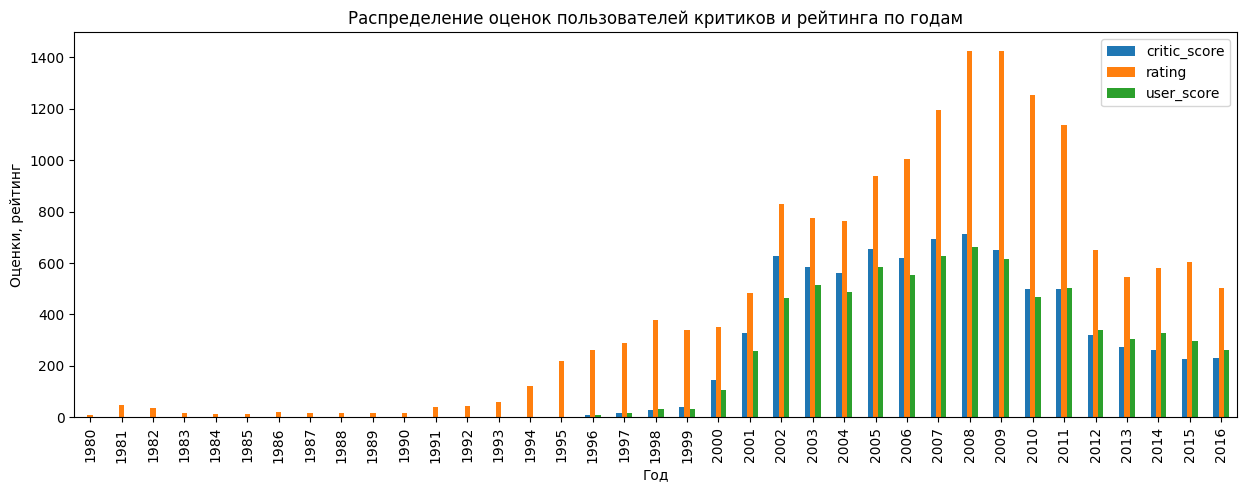

Доля оценок пользователей до 1996 года, %: 0.05360493165371214


In [33]:
games_data.pivot_table(index=['year_of_release'], values=['critic_score', 'user_score', 'rating'], aggfunc='count').plot(
figsize=(15,5),
kind='bar',
xlabel='Год',
ylabel='Оценки, рейтинг',
title='Распределение оценок пользователей критиков и рейтинга по годам')
plt.show()
print('Доля оценок пользователей до 1996 года, %:', 100*games_data[games_data['year_of_release']<1996]['user_score'].count()/games_data['user_score'].count())

**Предварительный вывод: период для анализа, за который в наличии подавляющая часть данных (95% и более) - с 1996 года по 2016 год. Доля оценок пользователей до 1996 года менее 5%, доля оценок критиков и рейтингов еще меньше. Аналогично дело обстоит и с продажами (см. п. 3.1). Так как платформы появляются и исчезают, для построения прогноза на 2017 год нужно исключить из рассмотрения данные по платформам, для которых не было продаж в течение двух последних лет (т.к. данные за 2016 год не полные, одного года будет не достаточно)**

Найдем актуальные платформы - те, для которых выходили игы и были продажи в последние 2 года (тк за 2016 год данные не полные)

In [34]:
actual_platforms= games_data[(games_data['year_of_release']>=2015) & (games_data['summary_sales']>0)]['platform'].unique()
print('Актуальные платформы:', actual_platforms)

Актуальные платформы: ['PS4' 'XOne' '3DS' 'WiiU' 'PS3' 'X360' 'PC' 'Wii' 'PSV' 'PSP']


Построим срез данных для прогноза на 2017 год по актуальным платформам, включим в него данные за последние годы (период продолжительностью в половину медианного значения срока жизни платформы плюс один год). Это примерно соответствует периоду, за который можно проследить рост или падение платформы судя по собранным данным

In [35]:
start_actual_period_year= np.floor(2016-platform_lifetime.median()/2+1).astype(int) 
start_actual_period_year

2013

In [36]:
print('Начальный год актуального периода прогноза:', start_actual_period_year)
games_data_actual= games_data[(games_data['platform'].isin(actual_platforms)) & (games_data['year_of_release']>=start_actual_period_year)]
games_data_actual.head(10)

Начальный год актуального периода прогноза: 2013


,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating,summary_sales
16,Grand Theft Auto V,PS3,2013,Action,7.02,9.09,0.98,3.96,97.0,8.2,M,14.03
23,Grand Theft Auto V,X360,2013,Action,9.66,5.14,0.06,1.41,97.0,8.1,M,6.61
31,Call of Duty: Black Ops 3,PS4,2015,Shooter,6.03,5.86,0.36,2.38,NaN,NaN,Not specified,8.60
33,Pokemon X/Pokemon Y,3DS,2013,Role-Playing,5.28,4.19,4.35,0.78,NaN,NaN,Not specified,9.32
42,Grand Theft Auto V,PS4,2014,Action,3.96,6.31,0.38,1.97,97.0,8.3,M,8.66
47,Pokemon Omega Ruby/Pokemon Alpha Sapphire,3DS,2014,Role-Playing,4.35,3.49,3.10,0.74,NaN,NaN,Not specified,7.33
60,Call of Duty: Ghosts,X360,2013,Shooter,6.73,2.56,0.04,0.91,73.0,2.6,M,3.51
69,Call of Duty: Ghosts,PS3,2013,Shooter,4.10,3.63,0.38,1.25,71.0,2.6,M,5.26
72,Minecraft,X360,2013,Misc,5.70,2.65,0.02,0.81,NaN,NaN,Not specified,3.48
77,FIFA 16,PS4,2015,Sports,1.12,6.12,0.06,1.28,82.0,4.3,E,7.46


### Отбор платформ, лидирующих по продажам за актуальный период

Визуализация тенденций изменения суммарных продаж во времени

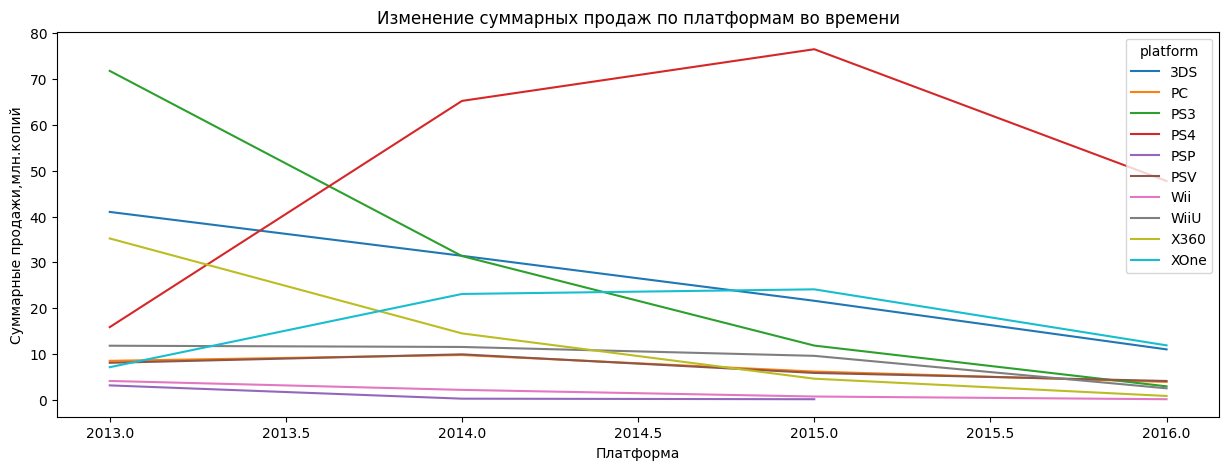

In [37]:
games_data_actual.pivot_table(index='year_of_release', columns='platform', values='summary_sales', aggfunc='sum').plot(
figsize=(15,5),
kind='line',
xlabel='Платформа',
ylabel='Суммарные продажи,млн.копий',
title='Изменение суммарных продаж по платформам во времени')
plt.show()

Визуализируем данные о продажах в разные годы для top-5 платформ (по объему продаж) за актуальный период

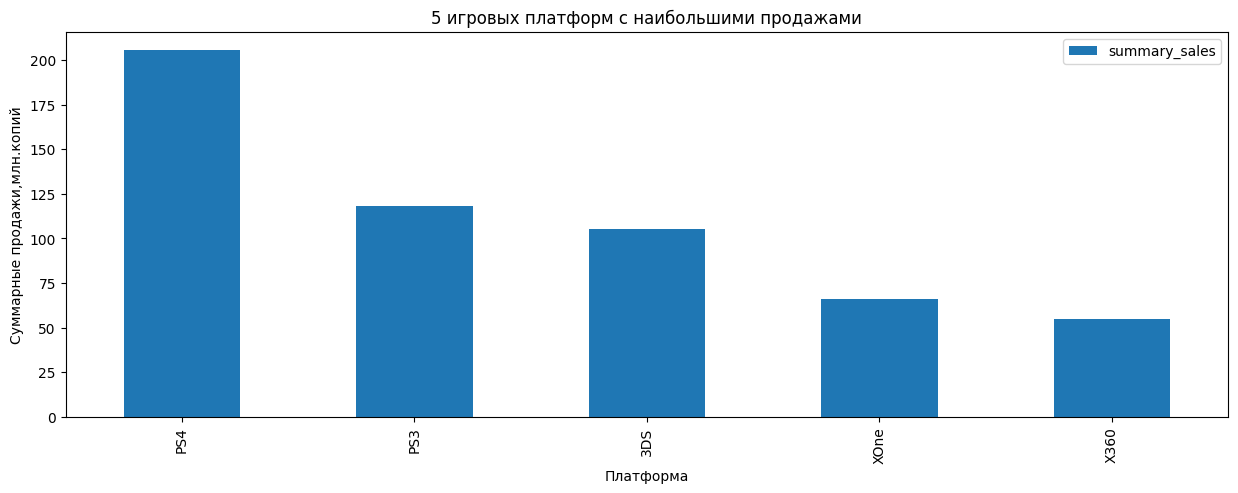

In [38]:
games_data_top= games_data_actual.pivot_table(index='platform', values='summary_sales', aggfunc='sum').sort_values('summary_sales', ascending= False)
games_data_top.head(5).plot(
figsize=(15,5),
kind='bar',
xlabel='Платформа',
ylabel='Суммарные продажи,млн.копий',
title='5 игровых платформ с наибольшими продажами')
plt.show()

**Вывод: лидируют по продажам за актуальный период платформы 'PS4', 'PS3', 'XOne', '3DS', 'X360'. При этом потенциально прибыльными на 2017 год (с учетом неполноты данных за 2016 год) я бы назвал 'PS4' и 'XOne' так как эти платформы достаточно "молодые" и показывали рост с 2013 по 2015 год, а спад в 2016 может быть вызван неполнотой данных. Остальные платформы более старые, находятся в состоянии спада по продажам игр и скорее всего продолжат падение.**

### Визуализация разброса глобальных (суммарных) продаж игр для различных платформ (ящик с усами)

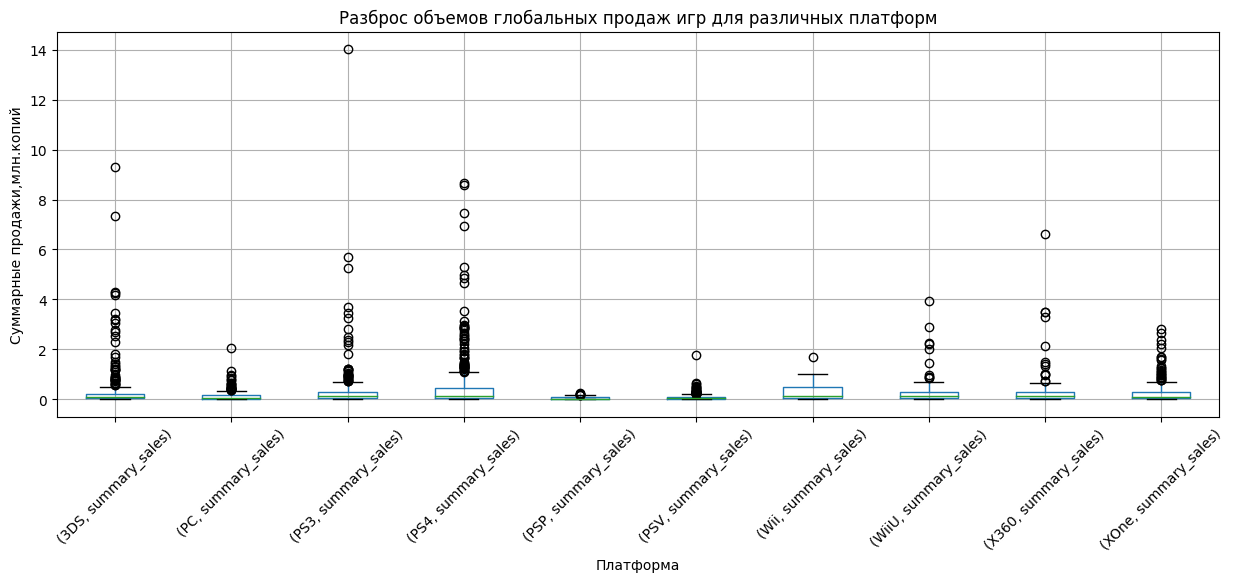

In [39]:
bp = games_data_actual.groupby('platform').boxplot(
subplots=False,
column='summary_sales', 
rot=45,
figsize=(15,5)
)
plt.ylabel('Суммарные продажи,млн.копий')
plt.xlabel('Платформа')
plt.title('Разброс объемов глобальных продаж игр для различных платформ')
plt.show()

Визуализация разброса глобальных (суммарных) продаж игр для различных платформ - с масштабированием

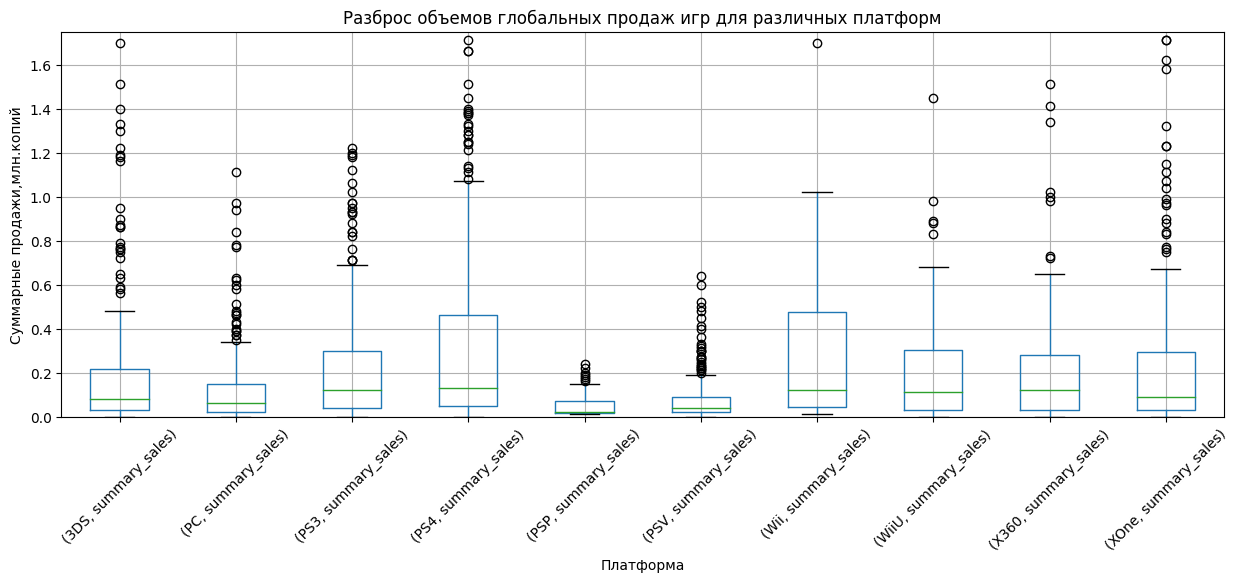

In [40]:
bp = games_data_actual.groupby('platform').boxplot(
subplots=False,
column='summary_sales', 
rot=45,
figsize=(15,5)
)
plt.ylabel('Суммарные продажи,млн.копий')
plt.xlabel('Платформа')
plt.title('Разброс объемов глобальных продаж игр для различных платформ')
bp.set_ylim(0, 1.75)
plt.show()

Посмотрим статистические показатели распределения суммарных продаж по платформам

In [41]:
games_data_actual.groupby('platform')['summary_sales'].describe()

,count,mean,std,min,25%,50%,75%,max
platform,,,,,,,,
3DS,303.0,0.346700,0.928592,0.00,0.0300,0.08,0.215,9.32
PC,189.0,0.149841,0.239657,0.00,0.0200,0.06,0.150,2.05
PS3,345.0,0.341826,0.966327,0.00,0.0400,0.12,0.300,14.03
PS4,392.0,0.523980,1.089547,0.00,0.0500,0.13,0.460,8.66
PSP,67.0,0.052239,0.059768,0.01,0.0150,0.02,0.070,0.24
PSV,358.0,0.078073,0.129491,0.00,0.0200,0.04,0.090,1.78
Wii,23.0,0.308696,0.422195,0.01,0.0450,0.12,0.475,1.70
WiiU,115.0,0.308000,0.581124,0.00,0.0300,0.11,0.305,3.94
X360,186.0,0.296452,0.682167,0.00,0.0325,0.12,0.280,6.61


Вычислим, сколько аномальных значений (игр) за пределами верхней границы усов для каждой платформы

In [42]:
actual_platforms= games_data_actual['platform'].unique()
pl_sales= games_data_actual.groupby('platform')['summary_sales'].quantile([0.25, 0.75])
for pltf in actual_platforms:
    platform_sales_count= len(games_data_actual[games_data_actual['platform']==pltf])
    iqr=pl_sales[pltf][0.75]-pl_sales[pltf][0.25]
    upper_level= pl_sales[pltf][0.75]+ 1.5*iqr
    anomal_values_cnt= games_data_actual[(games_data_actual['platform']==pltf) & (games_data_actual['summary_sales']>upper_level)]['platform'].count()
    anomal_values_percerntage= 100*anomal_values_cnt/platform_sales_count
    display(f'Для платформы {pltf} количество игр с продажами более 1,5 IQR составляет {anomal_values_percerntage.round(1)}%')

'Для платформы PS3 количество игр с продажами более 1,5 IQR составляет 9.6%'

'Для платформы X360 количество игр с продажами более 1,5 IQR составляет 7.0%'

'Для платформы PS4 количество игр с продажами более 1,5 IQR составляет 13.5%'

'Для платформы 3DS количество игр с продажами более 1,5 IQR составляет 12.9%'

'Для платформы XOne количество игр с продажами более 1,5 IQR составляет 10.5%'

'Для платформы WiiU количество игр с продажами более 1,5 IQR составляет 8.7%'

'Для платформы Wii количество игр с продажами более 1,5 IQR составляет 4.3%'

'Для платформы PC количество игр с продажами более 1,5 IQR составляет 12.7%'

'Для платформы PSV количество игр с продажами более 1,5 IQR составляет 8.1%'

'Для платформы PSP количество игр с продажами более 1,5 IQR составляет 10.4%'

**Вывод: по графику можно сделать вывод, что медианное значение и межквартильный интервал продаж игр по крайней мере наиболее успешных платформ (PS4, Wii, X360, XOne) имеют близкие значения (медиана в районе 0,2 и межквартильный интервал в пределах 0,8 млн. копий). Несколько ниже средний показатель у платформы 3DS (менее 0,1 млн.копий). При этом у всех пяти лидирующих платформ 8% и более отдельных игр с более успешными продажами с количеством копий за пределами 1,5 IQR**

### Анализ влияния на продажи внутри одной популярной платформы отзывов пользователей и критиков

Построим диаграмму рассеяния для зависимости продаж от отзывов пользователей для платформы 'PS4' (лидер продаж)

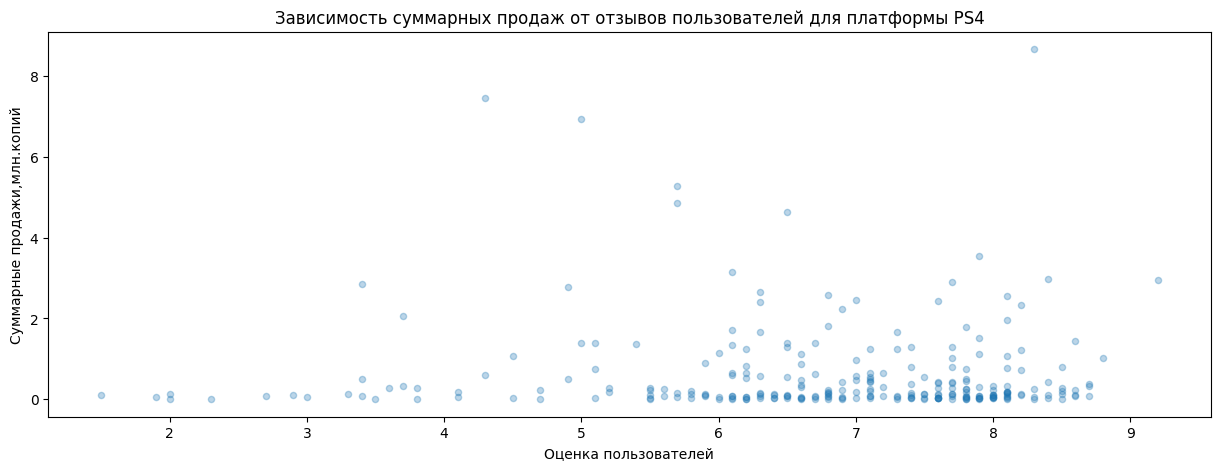

-0.03491834368737526

In [43]:
df_ps4= games_data_actual[games_data_actual['platform']=='PS4']
df_ps4.plot(
figsize=(15,5),
x='user_score', 
y='summary_sales', 
kind='scatter',
alpha=0.3,
xlabel='Оценка пользователей',
ylabel='Суммарные продажи,млн.копий',
title='Зависимость суммарных продаж от отзывов пользователей для платформы PS4')
plt.show()
#посчитаем коэффициент корреляции пирсона
df_ps4['user_score'].corr(df_ps4['summary_sales'])

Построим диаграмму рассеяния для зависимости продаж от отзывов критиков для платформы 'PS4' (лидер продаж)

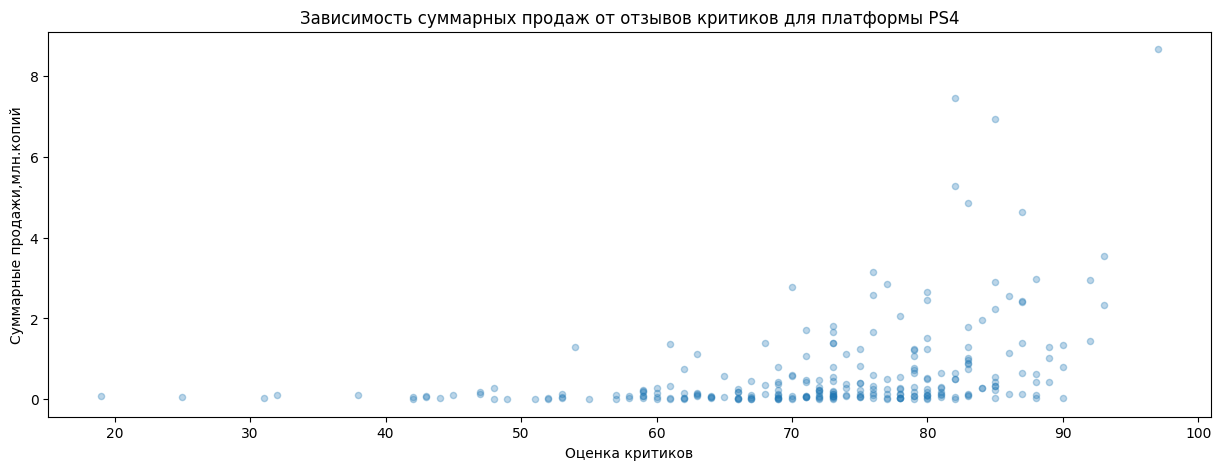

0.37185703410677745

In [44]:
df_ps4.plot(
figsize=(15,5),
x='critic_score', 
y='summary_sales', 
kind='scatter',
alpha=0.3,
xlabel='Оценка критиков',
ylabel='Суммарные продажи,млн.копий',
title='Зависимость суммарных продаж от отзывов критиков для платформы PS4')
plt.show()
df_ps4['critic_score'].corr(df_ps4['summary_sales'])

**Вывод: судя по графикам и коэффициенту корреляции, отзывы пользователей почти не влияют на продажу игр для популярной платформы 'PS4', отзывы критиков имеют большее влияние на продажи, данные указыают на умеренную положительную связь**

### Анализ влияния на продажи внутри других популярных платформ отзывов пользователей и критиков

Построим диаграмму рассеивания для зависимости отзывов пользователей на продажи 
и найдем коэффициент корреляции для 5 других популярных платформ

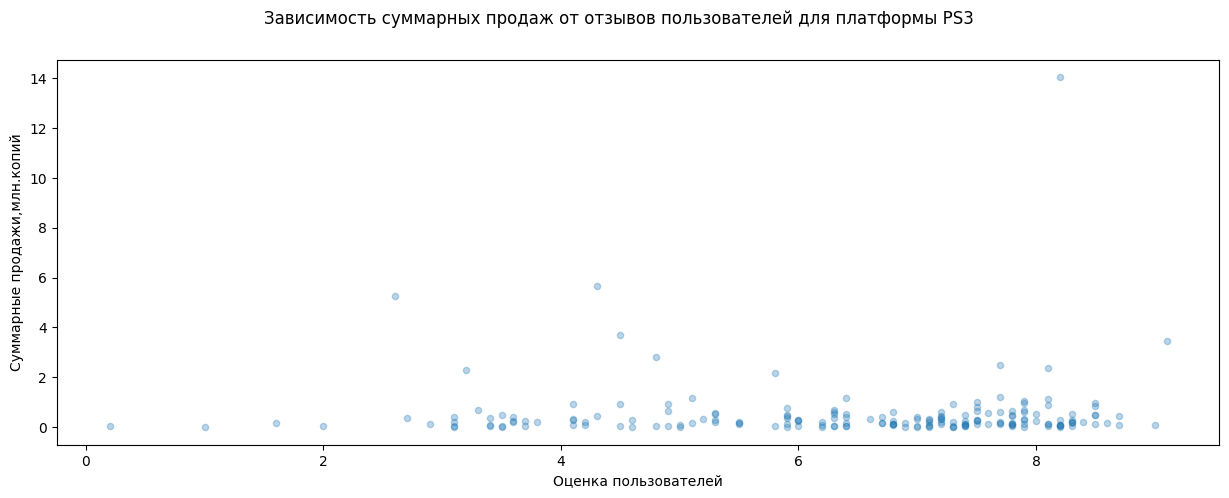

Коэффициент корреляции: 0.010765895805889738


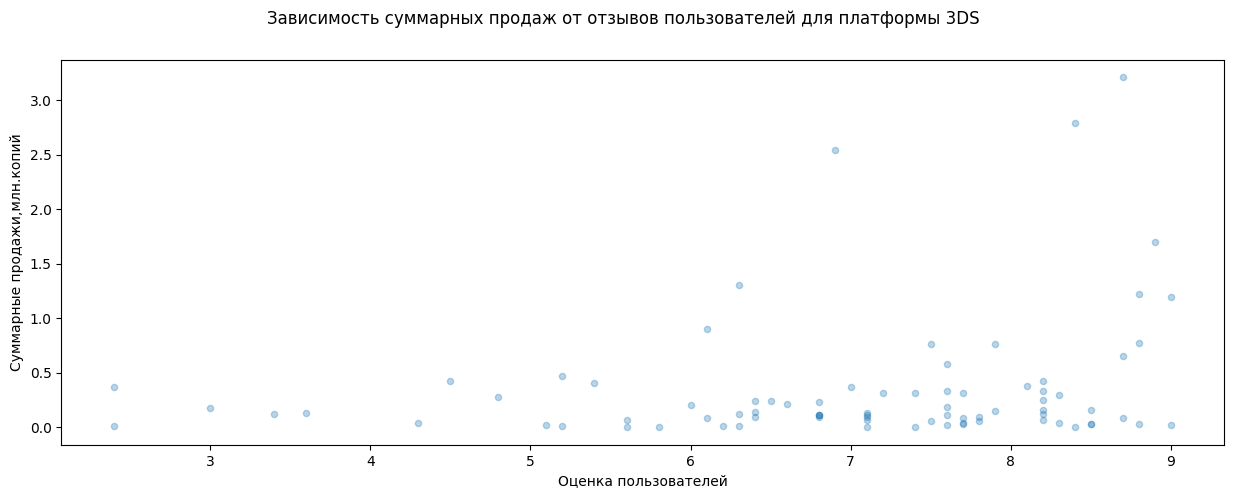

Коэффициент корреляции: 0.22499579540159328


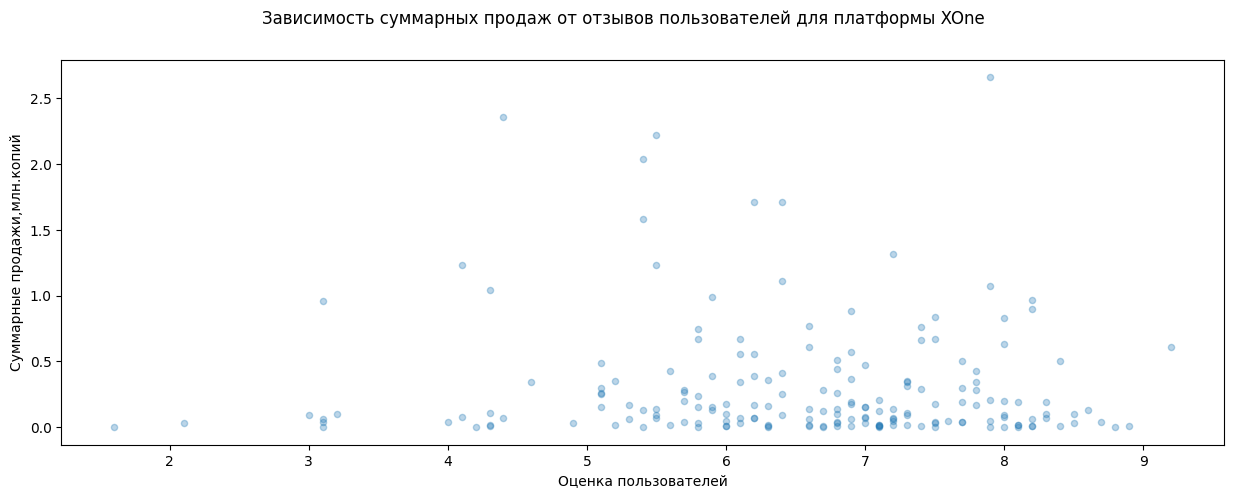

Коэффициент корреляции: -0.059279147354701016


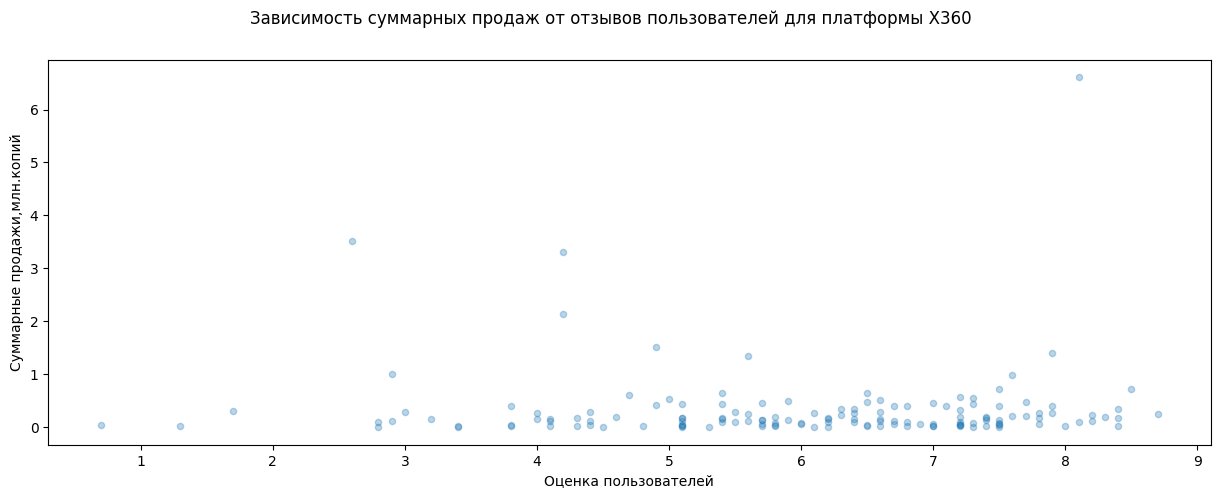

Коэффициент корреляции: -0.010117789459546746


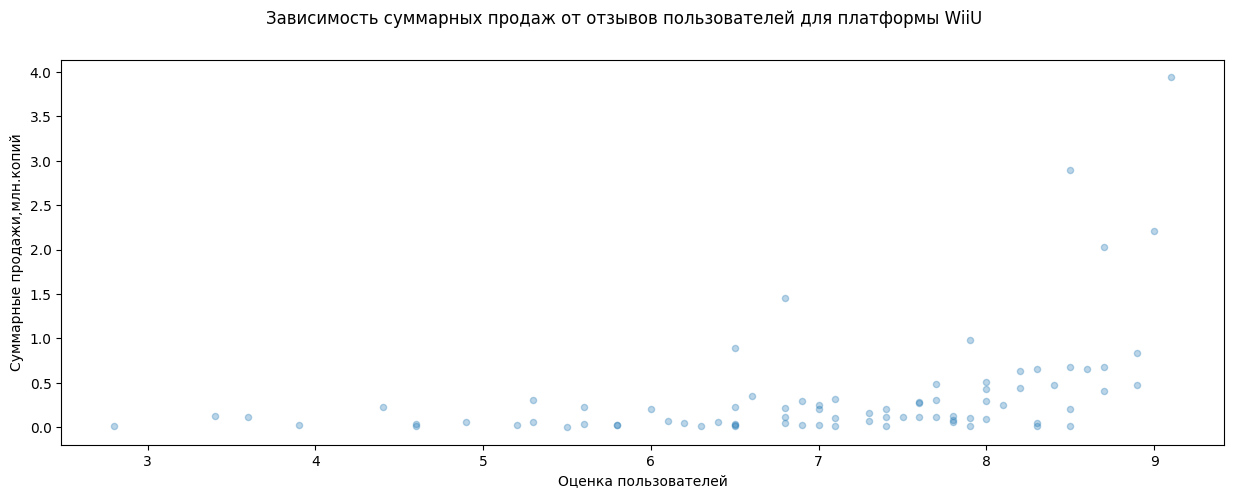

Коэффициент корреляции: 0.4133366161048785


In [45]:
games_data_top= games_data_actual.pivot_table(index='platform', values='summary_sales', aggfunc='sum').sort_values('summary_sales', ascending= False)
for pltf in games_data_top.head(6).index:
    if pltf=='PS4':
        continue
    df_pltf= games_data_actual[games_data_actual['platform']==pltf]
    df_pltf.plot(
    figsize=(15,5),
    subplots=True,
    x='user_score', 
    y='summary_sales', 
    kind='scatter',
    alpha=0.3,
    xlabel='Оценка пользователей',
    ylabel='Суммарные продажи,млн.копий',
    title=f'Зависимость суммарных продаж от отзывов пользователей для платформы {pltf}')
    plt.show()
    cc= df_pltf['user_score'].corr(df_pltf['summary_sales'])
    print(f'Коэффициент корреляции: {cc}')

Построим диаграмму рассеивания для зависимости отзывов критиков на продажи 
и найдем коэффициент корреляции для 5 других популярных платформ

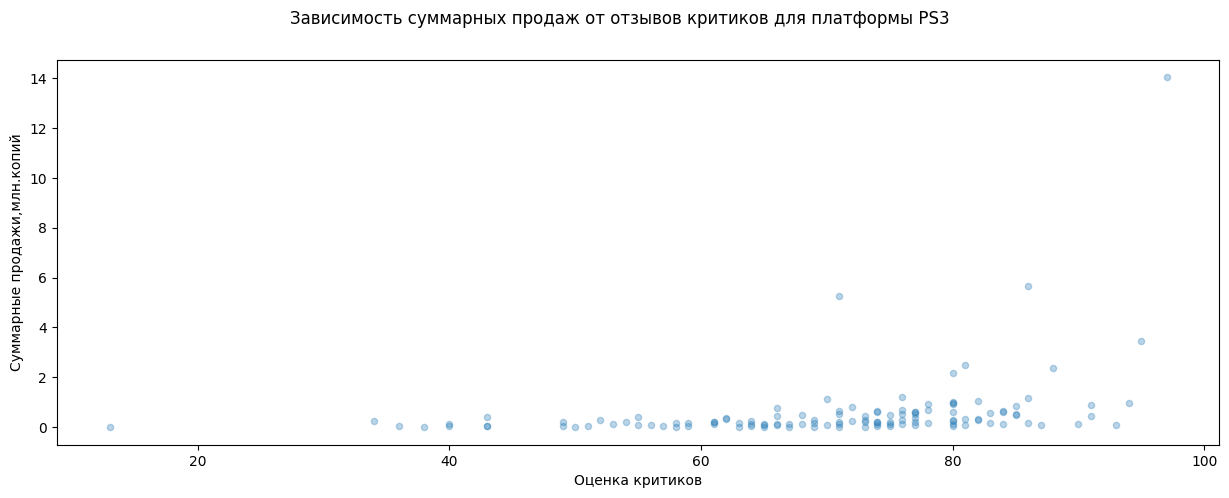

Коэффициент корреляции: 0.32310000521547266


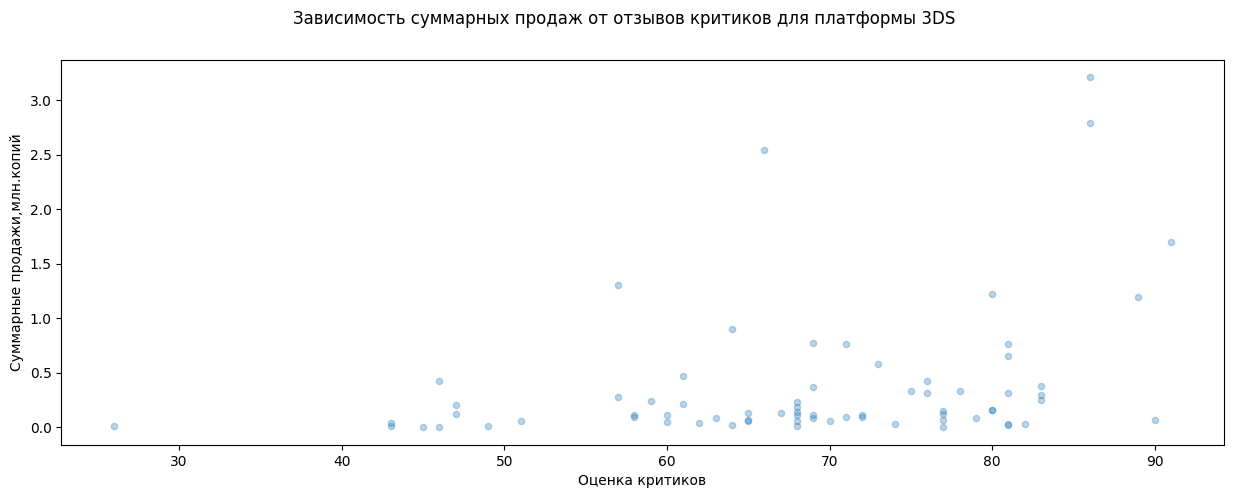

Коэффициент корреляции: 0.32591202532058544


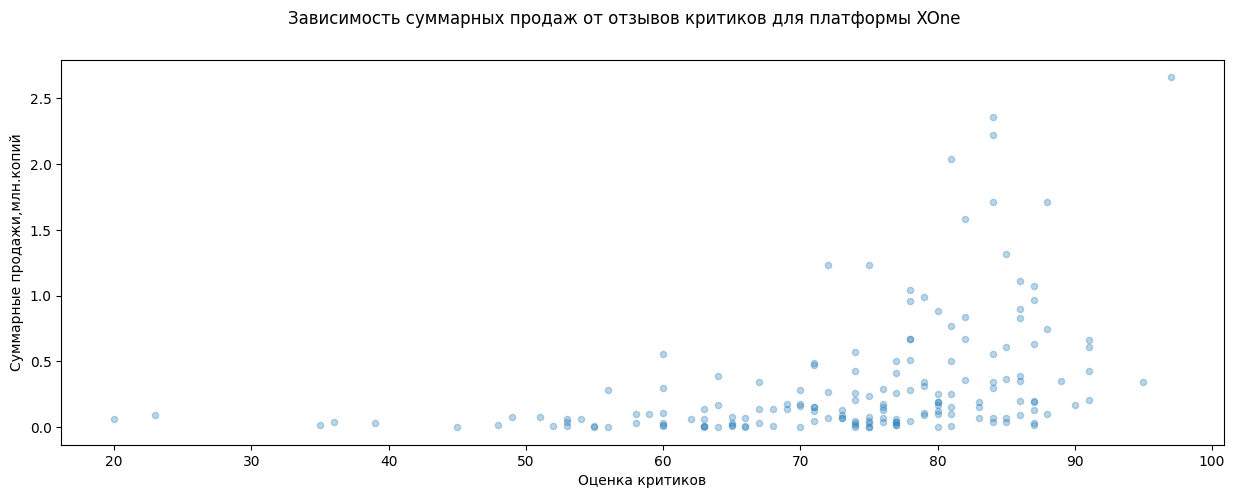

Коэффициент корреляции: 0.3984082260297794


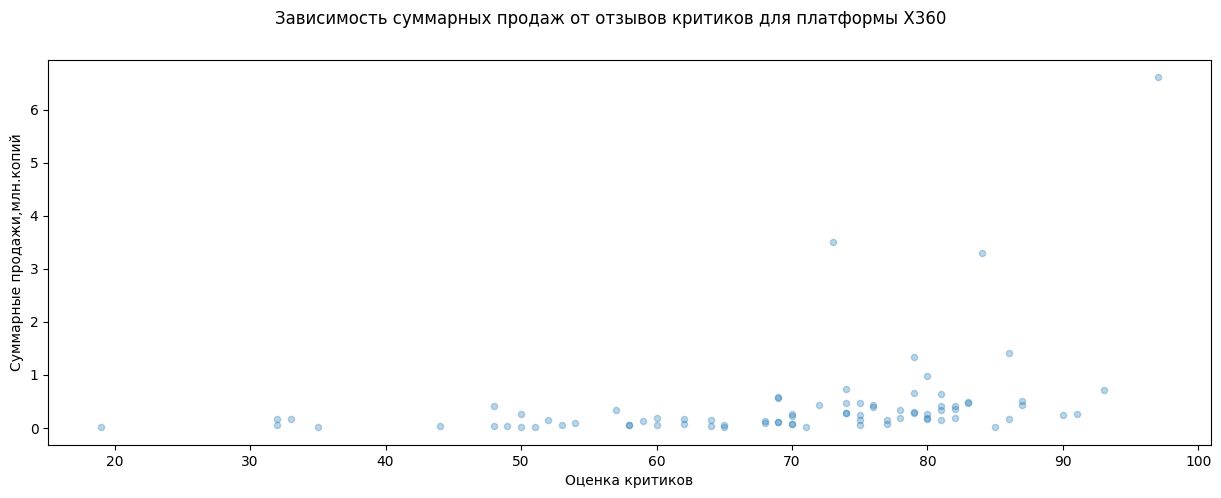

Коэффициент корреляции: 0.34274607773107435


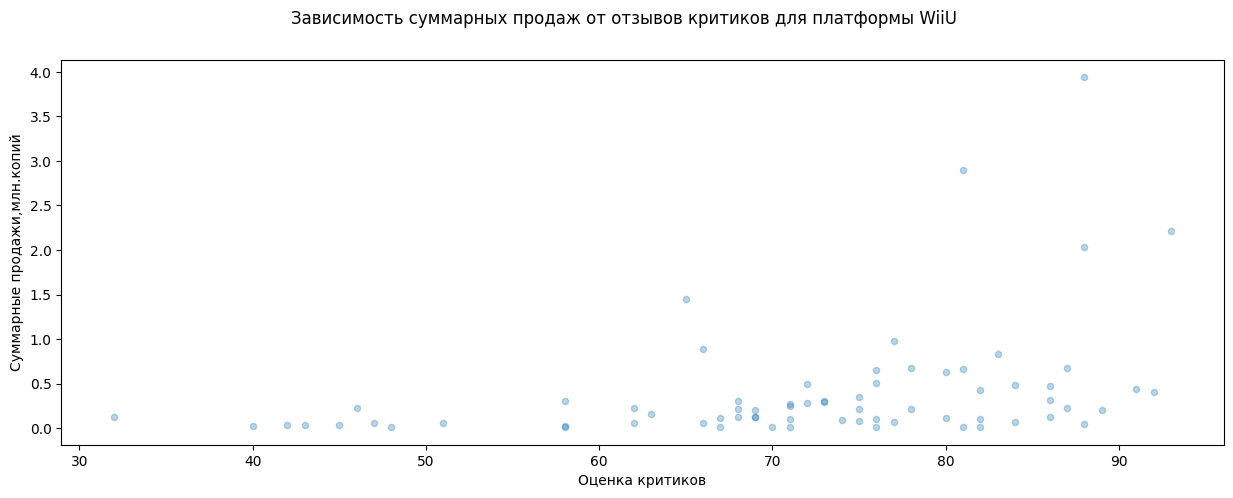

Коэффициент корреляции: 0.3585360806833907


In [46]:
for pltf in games_data_top.head(6).index:
    if pltf=='PS4':
        continue
    df_pltf= games_data_actual[games_data_actual['platform']==pltf]
    df_pltf.plot(
    figsize=(15,5),
    subplots=True,
    x='critic_score', 
    y='summary_sales', 
    kind='scatter',
    alpha=0.3,
    xlabel='Оценка критиков',
    ylabel='Суммарные продажи,млн.копий',
    title=f'Зависимость суммарных продаж от отзывов критиков для платформы {pltf}')
    plt.show()
    cc= df_pltf['critic_score'].corr(df_pltf['summary_sales'])
    print(f'Коэффициент корреляции: {cc}')

**Вывод: судя коэффициенту корреляции, отзывы отзывы критиков имеют умеренную положительную связь с продажами (чем выше оценка, тем выше продажи). Отзывы пользователей практически не оказывают влияния на продажи для платформ PS3, XOne, X360, но для платформ 3DS и WiiU отмечена умеренная положительная связь c продажами.**

### Распределение продаж игр по жанрам

Визуализируем данные о суммарных продажах для различных жанров

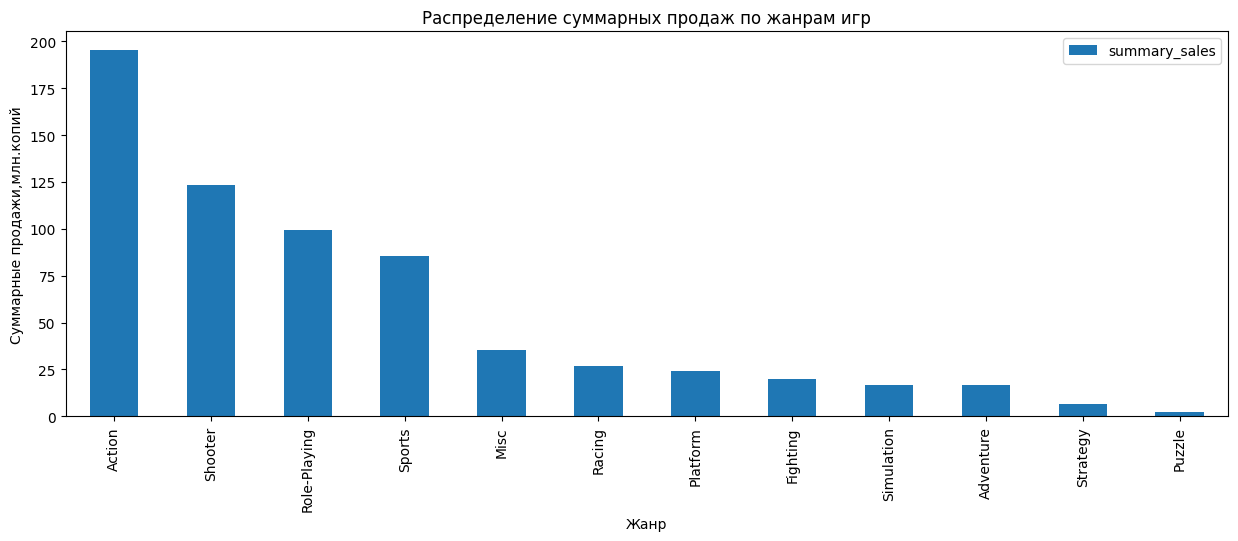

In [47]:
games_data_top= games_data_actual.pivot_table(index=['genre'], values=['summary_sales'], aggfunc='sum').sort_values('summary_sales', ascending= False).plot(
figsize=(15,5),
kind='bar',
xlabel='Жанр',
ylabel='Суммарные продажи,млн.копий',
title='Распределение суммарных продаж по жанрам игр')
plt.show()

Визуализируем данные о медианных продажах для различных жанров

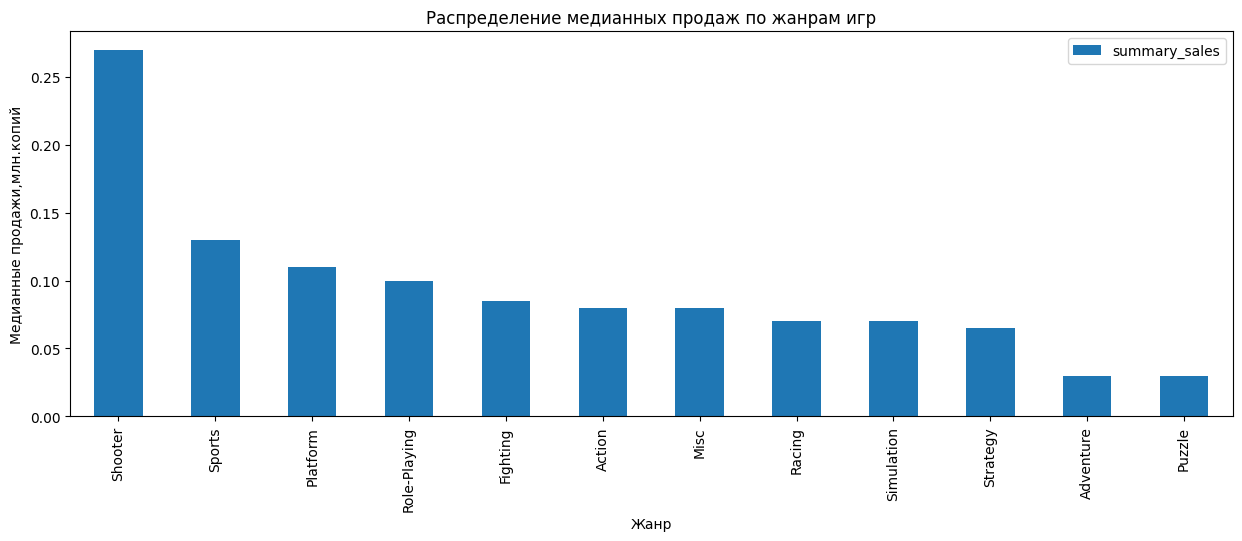

In [48]:
games_data_top= games_data_actual.pivot_table(index=['genre'], values=['summary_sales'], aggfunc='median').sort_values('summary_sales', ascending= False).plot(
figsize=(15,5),
kind='bar',
xlabel='Жанр',
ylabel='Медианные продажи,млн.копий',
title='Распределение медианных продаж по жанрам игр')
plt.show()

Построим диаграммы размаха для различных жанров

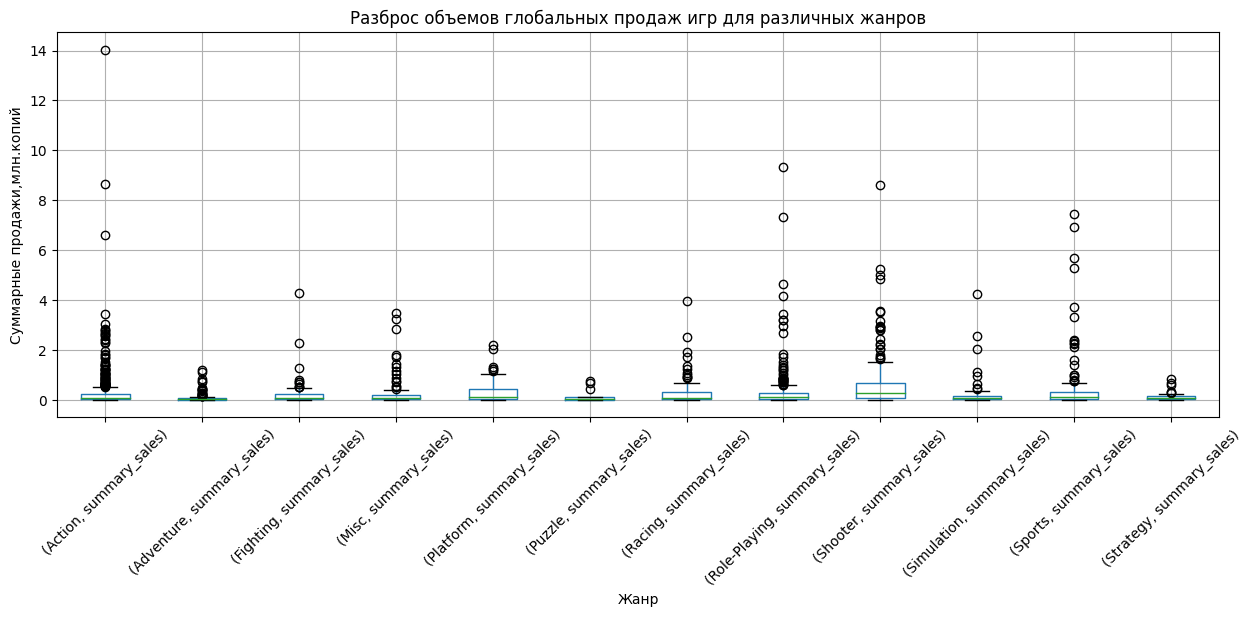

In [49]:
bp = games_data_actual.groupby('genre').boxplot(
subplots=False,
column='summary_sales', 
rot=45,
figsize=(15,5)
)
plt.ylabel('Суммарные продажи,млн.копий')
plt.xlabel('Жанр')
plt.title('Разброс объемов глобальных продаж игр для различных жанров')
plt.show()

Построим диаграммы размаха для различных жанров с масштабированием

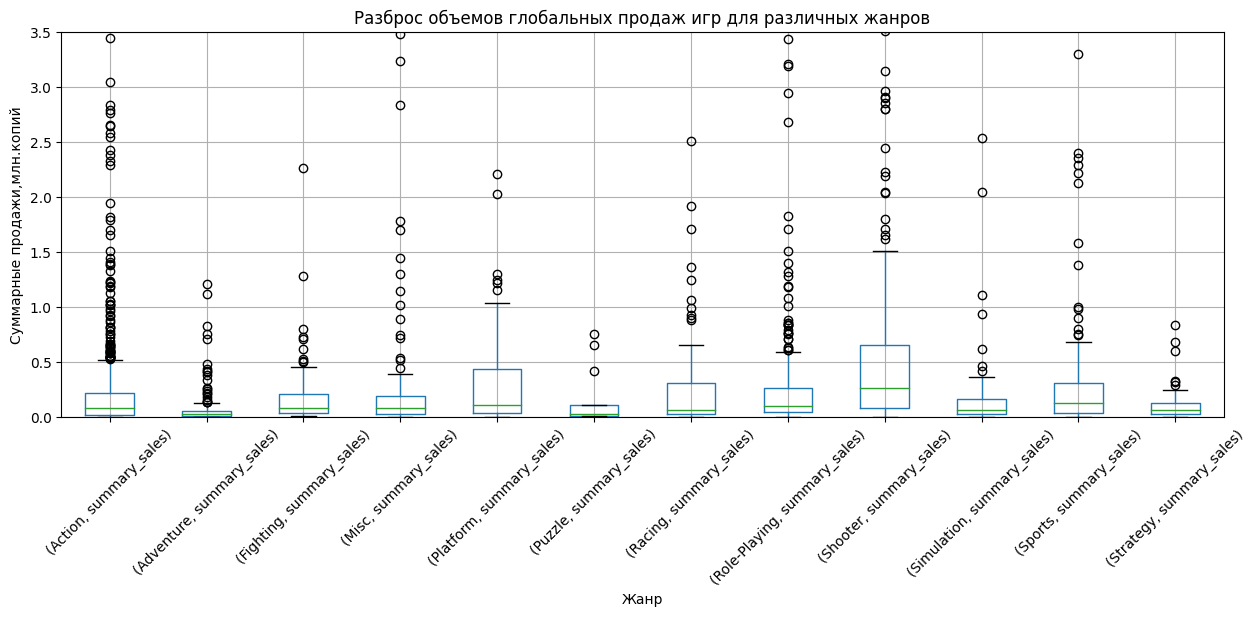

In [50]:
bp = games_data_actual.groupby('genre').boxplot(
subplots=False,
column='summary_sales', 
rot=45,
figsize=(15,5)
)
plt.ylabel('Суммарные продажи,млн.копий')
plt.xlabel('Жанр')
plt.title('Разброс объемов глобальных продаж игр для различных жанров')
bp.set_ylim(0, 3.5)
plt.show()

**Вывод:к самым прибыльным "в среднем" жанрам относятся "Shooter" и "Sports". Медианные продажи игр этих жанров в несколько раз превышают многие менее популярные. Следующими в пятерке жанров-лидеров идут "Platform", "Role-playing" и "Fighting". При этом суммарные продажи жанра Action являются наибольшими, но в среднем игры этого жанра имеют меньшие продажи, чем вышеперечисленные. Суммарные продажи повышаются для этого жанра за счет отдельных игры под популярные платформы, что подтверждает диаграмма размаха (она показывает большое количество выбросов для этого жанра).**

## Шаг 4. Составление портрета пользователя каждого региона

### Определение для пользователя каждого региона (NA, EU, JP) самых популярных платформ (топ-5)

Отбор top-5 платформ по Северной Америке, остальные платформы помещаем в категорию "Другие"

In [51]:
platform_na_sales_top5= games_data_actual.groupby('platform')['na_sales'].apply(lambda g: g.sum()).sort_values(ascending= False).head(5)
platform_na_sales_top5['Другие']= games_data_actual['na_sales'].sum()-platform_na_sales_top5.sum()
platform_na_sales_top5

platform
PS4       108.74
XOne       93.12
X360       81.66
PS3        63.50
3DS        38.20
Другие     51.92
Name: na_sales, dtype: float64

Отбор top-5 платформ по Европе, остальные платформы помещаем в категорию "Другие"

In [52]:
platform_eu_sales_top5= games_data_actual.groupby('platform')['eu_sales'].apply(lambda g: g.sum()).sort_values(ascending= False).head(5)
platform_eu_sales_top5['Другие']= games_data_actual['eu_sales'].sum()-platform_eu_sales_top5.sum()
platform_eu_sales_top5

platform
PS4       141.09
PS3        67.81
XOne       51.59
X360       42.52
3DS        30.96
Другие     57.41
Name: eu_sales, dtype: float64

Отбор top-5 платформ по Японии, остальные платформы помещаем в категорию "Другие"

In [53]:
platform_jp_sales_top5= games_data_actual.groupby('platform')['jp_sales'].apply(lambda g: g.sum()).sort_values(ascending= False).head(5)
platform_jp_sales_top5['Другие']= games_data_actual['jp_sales'].sum()-platform_jp_sales_top5.sum()
platform_jp_sales_top5

platform
3DS       67.81
PS3       23.35
PSV       18.59
PS4       15.96
WiiU      10.88
Другие     4.19
Name: jp_sales, dtype: float64

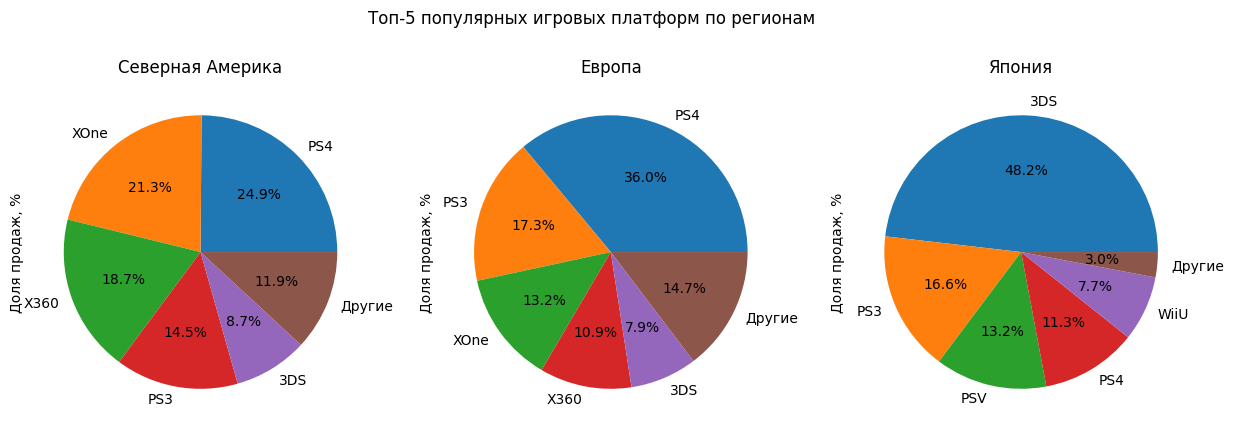

In [54]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(15,5))
fig.suptitle('Топ-5 популярных игровых платформ по регионам')
platform_na_sales_top5.plot(
ax=ax1,
grid= True,
kind='pie',
autopct='%1.1f%%',
ylabel='Доля продаж, %',
title='Северная Америка')
platform_eu_sales_top5.plot(
ax=ax2,
grid= True,
kind='pie',
autopct='%1.1f%%',
ylabel='Доля продаж, %',
title='Европа')
platform_jp_sales_top5.plot(
grid= True,
kind='pie',
autopct='%1.1f%%',
ylabel='Доля продаж, %',
title='Япония')
plt.show()

**Вывод: в Северной Америке лидирует платформа PS4 от Sony, занимая 24,9% рынка. Еще 2 платформы-лидера- XOne и X360 от Microsoft (21,3% и 18,7% соответственно), четвертое место у PS3 от Sony (14,5%). Замыкает пятерку лидеров по объему продаж 3DS от Nintendo c долей рынка в районе 8%). Прочие платформы занимают менее 12% рынка. В Европе лидирует PS4 от Sony c 36% рынка, лидирующие позиции у PS3 от Sony и XOne от Microsoft (17,3% и 13,2% соответственно).На четвертом месте X360 от Microsoft (10,9%), на пятом 3DS от Nintendo (7,9%). Прочие платформы занимают 14,7% рынка.  
В Японии большую популярность имеют портативные игровые консоли: лидирует платформа 3DS (48,2% рынка), второе место у Sony PS3 c 16,6%, затем портативная консоль Sony PSV (13,2%), на четвертом месте PS4 от Sony (11,3%) и замыкает пятерку лидеров WiiU от Nintendo с 7,7%. На долю других платформ в Японии приходится только 3% рынка**

### Определение для пользователя каждого региона (NA, EU, JP) самых популярных жанров (топ-5)

Отбор top-5 жанров в Северной Америке, остальные жанры помещаем в категорию "Другие"

In [55]:
genre_na_sales_top5= games_data_actual.groupby('genre')['na_sales'].apply(lambda g: g.sum()).sort_values(ascending= False).head(5)
genre_na_sales_top5['Другие']= games_data_actual['na_sales'].sum()-genre_na_sales_top5.sum()
genre_na_sales_top5

genre
Action          125.83
Shooter         109.74
Sports           65.27
Role-Playing     46.40
Misc             27.46
Другие           62.44
Name: na_sales, dtype: float64

Отбор top-5 жанров в Европе, остальные жанры помещаем в категорию "Другие"

In [56]:
genre_eu_sales_top5= games_data_actual.groupby('genre')['eu_sales'].apply(lambda g: g.sum()).sort_values(ascending= False).head(5)
genre_eu_sales_top5['Другие']= games_data_actual['eu_sales'].sum()-genre_eu_sales_top5.sum()
genre_eu_sales_top5

genre
Action          117.89
Shooter          87.86
Sports           60.49
Role-Playing     36.97
Racing           20.19
Другие           67.98
Name: eu_sales, dtype: float64

Отбор top-5 жанров в Японии, остальные жанры помещаем в категорию "Другие"

In [57]:
genre_jp_sales_top5= games_data_actual.groupby('genre')['jp_sales'].apply(lambda g: g.sum()).sort_values(ascending= False).head(5)
genre_jp_sales_top5['Другие']= games_data_actual['jp_sales'].sum()-genre_jp_sales_top5.sum()
genre_jp_sales_top5

genre
Role-Playing    51.04
Action          40.49
Misc             9.20
Fighting         7.65
Shooter          6.61
Другие          25.79
Name: jp_sales, dtype: float64

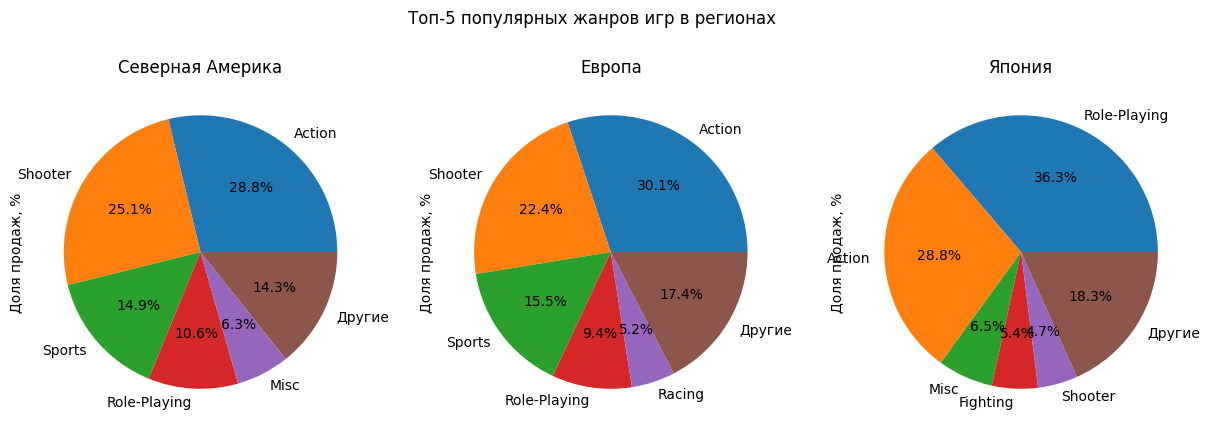

In [58]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(15,5))
fig.suptitle('Топ-5 популярных жанров игр в регионах')
genre_na_sales_top5.plot(
ax=ax1,
grid= True,
kind='pie',
autopct='%1.1f%%',
ylabel='Доля продаж, %',
title='Северная Америка')
genre_eu_sales_top5.plot(
ax=ax2,
grid= True,
kind='pie',
autopct='%1.1f%%',
ylabel='Доля продаж, %',
title='Европа')
genre_jp_sales_top5.plot(
grid= True,
kind='pie',
autopct='%1.1f%%',
ylabel='Доля продаж, %',
title='Япония')
plt.show()

**Вывод: в Северной Америке и Европе по жанрам похожее распределение продаж: лидирует жанр "Action" (28,8% и 30,1%) соответственно, затем "Shooter" (25,1% и 22,4%), затем "Sports" (14,9% и 15,5%), затем "Role-Playing" (10,6% и 9,4%), на 5-ом месте в Северной Америке "Misc" (6,3%), в Европе "Racing" (5,2%). Прочие жанры занимают 14,3% рынка в Северной Америке и 17,4% в Европе. В Японии лидирует жанр ролевых игр ("Role-playing") c долей рынка 36,3%. Подвижные игры жанра Action также пользуются популярностью (более 28,8%), доля "Misc", "Fighting" и "Shooter" составляет 6,5%, 5,4% и 4,7% соответственно. Другие жанры в сумме занимают 18,3% рынка.**

### Определение для пользователя каждого региона (NA, EU, JP) влияет ли рейтинг ESRB на продажи в отдельном регионе

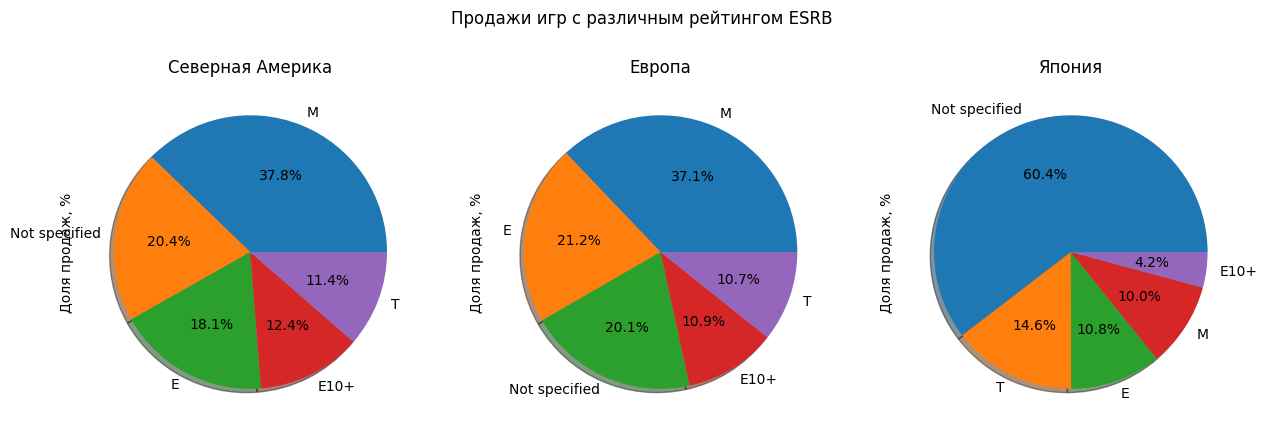

In [59]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(15,5))
fig.suptitle('Продажи игр с различным рейтингом ESRB')
games_data_actual.groupby('rating')['na_sales'].sum().sort_values(ascending= False).plot(
ax=ax1,
kind='pie',
autopct='%1.1f%%', 
shadow=True,
ylabel='Доля продаж, %',
title='Северная Америка')
games_data_actual.groupby('rating')['eu_sales'].sum().sort_values(ascending= False).plot(
ax=ax2,
kind='pie',
autopct='%1.1f%%', 
shadow=True,
ylabel='Доля продаж, %',
title='Европа')
games_data_actual.groupby('rating')['jp_sales'].sum().sort_values(ascending= False).plot(
kind='pie',
autopct='%1.1f%%', 
shadow=True,
ylabel='Доля продаж, %',
title='Япония')
plt.show()

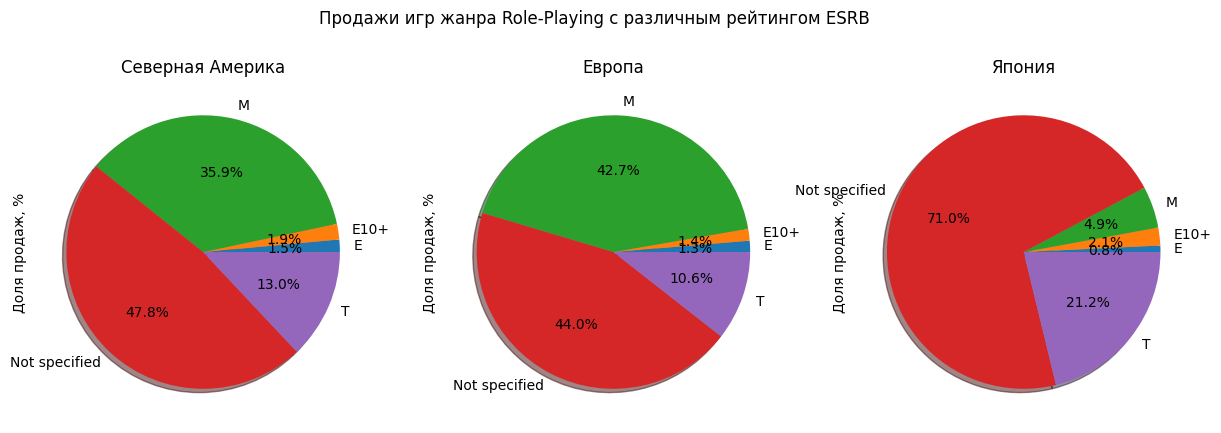

In [60]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(15,5))
fig.suptitle('Продажи игр жанра Role-Playing с различным рейтингом ESRB')
games_data_actual[games_data_actual['genre']=='Role-Playing'].groupby('rating')['na_sales'].sum().plot(
ax=ax1,
kind='pie',
autopct='%1.1f%%', 
shadow=True,
ylabel='Доля продаж, %',
title='Северная Америка')
games_data_actual[games_data_actual['genre']=='Role-Playing'].groupby('rating')['eu_sales'].sum().plot(
ax=ax2,
kind='pie',
autopct='%1.1f%%', 
shadow=True,
ylabel='Доля продаж, %',
title='Европа')
games_data_actual[games_data_actual['genre']=='Role-Playing'].groupby('rating')['jp_sales'].sum().plot(
ax=ax3,
kind='pie',
autopct='%1.1f%%', 
shadow=True,
ylabel='Доля продаж, %',
title='Япония')
plt.show()

**Вывод: Судя по тому, что в Северной Америке, где присваивается рейтинг ESRB для игр при продаже и в Европе, где он не обязателен популярность игр с одинаковым рейтингом распределена практически одинаково, большую долю (более 20%) популярности занимают игры без рейтинга (а в Японии доля популярных игр без рейтинга более 60%) - можно сделать вывод, что присвоение рейтинга не влияет на популярность игры.**

## Шаг 5. Проверка гипотез о пользовательском рейтинге платформ и жанров

### Проверка гипотезы, что средние пользовательские рейтинги платформ Xbox One и PC одинаковые

Сделаем срез для пользовательского рейтинга под платформу XOne

In [61]:
xbox_score= games_data_actual[games_data_actual['platform']=='XOne']['user_score']
xbox_score.describe()

count    182.000000
mean       6.521429
std        1.380941
min        1.600000
25%        5.800000
50%        6.800000
75%        7.500000
max        9.200000
Name: user_score, dtype: float64

Сделаем срез для пользовательского рейтинга под платформу PC

In [62]:
pc_score=games_data_actual[games_data_actual['platform']=='PC']['user_score']
pc_score.describe()

count    155.000000
mean       6.269677
std        1.742381
min        1.400000
25%        5.300000
50%        6.800000
75%        7.600000
max        9.300000
Name: user_score, dtype: float64

Проведем двухсторонний t-test о равенстве средних для выборок пользовательских рейтингов платформ Xbox One и PC
<ul>гипотеза H0 -средние пользовательские рейтинги платформ Xbox One и PC одинаковые</ul>
<ul>гипотеза H1 - средние пользовательские рейтинги платформ Xbox One и PC разные</ul>

In [63]:
alpha = 0.05 # уровень статистической значимости

results = st.ttest_ind(xbox_score.dropna(), pc_score.dropna(), equal_var=False )

print('p-значение:', results.pvalue)

if results.pvalue < alpha:
    print('Отвергаем нулевую гипотезу о равенстве средних')
else:
    print('Не получилось отвергнуть нулевую гипотезу')

p-значение: 0.14759594013430463
Не получилось отвергнуть нулевую гипотезу


**Вывод: для проверки гипотезы, что средние пользовательские рейтинги платформ Xbox One и PC равны, сформулирована нулевая гипотеза H0 о равенстве средних для выборок пользовательских рейтингов платформ Xbox One и PC и альтернативная H1- что средние для пользовательских рейтингов не равны. Так как нет причин подозревать, что генеральные совокупности для пользовательских рейтингов зависят друг от друга, применен двусторонний t-тест о равенстве средних. В  результате гипотеза H0 о равенстве средних не отвергнута, что подтверждается близкими значениями средних для выборок.** 

### Проверка гипотезы, что средние пользовательские рейтинги жанров Action и Sports разные

Сделаем срез для пользовательского рейтинга жанра Action

In [64]:
genre_action_score= games_data_actual[games_data_actual['genre']=='Action']['user_score']
genre_action_score.describe()

count    388.000000
mean       6.842784
std        1.327847
min        2.000000
25%        6.300000
50%        7.100000
75%        7.800000
max        9.100000
Name: user_score, dtype: float64

Сделаем срез для пользовательского рейтинга жанра Sports

In [65]:
genre_sports_score= games_data_actual[games_data_actual['genre']=='Sports']['user_score']
genre_sports_score.describe()

count    160.000000
mean       5.238125
std        1.783427
min        0.200000
25%        4.100000
50%        5.500000
75%        6.500000
max        8.800000
Name: user_score, dtype: float64

Проведем двухсторонний t-test о равенстве средних для выборок пользовательских рейтингов жанров Action и Sports
<ul>гипотеза H0 -средние пользовательские рейтинги жанров Action и Sports одинаковые</ul>
<ul>гипотеза H1 - средние пользовательские рейтинги жанров Action и Sports разные</ul>

In [66]:
alpha = 0.05 # уровень статистической значимости

results = st.ttest_ind(genre_action_score.dropna(), genre_sports_score.dropna(), equal_var=False )

print('p-значение:', results.pvalue)

if results.pvalue < alpha:
    print('Отвергаем нулевую гипотезу о равенстве средних')
else:
    print('Не получилось отвергнуть нулевую гипотезу')

p-значение: 1.1330204667098058e-20
Отвергаем нулевую гипотезу о равенстве средних


**Вывод: для проверки гипотезы, что средние пользовательские рейтинги жанров Action и Sports равны, сформулирована нулевая гипотеза H0 о равенстве средних для выборок пользовательских рейтингов жанров Action и Sports и альтернативная H1 - что средние для пользовательских рейтингов не равны (разные). Так как нет причин подозревать, что генеральные совокупности для пользовательских рейтингов зависят друг от друга, применен двусторонний t-тест о равенстве средних. В  результате гипотеза H0 о равенстве средних отвергнута.** 

<b><u>Итоговые выводы:</u></b>
<b><p>Рекламный бюджет стоит потратить в 2017 году на игры под платформы "PS4" и "XOne"- если выбирать регион продаж "Северная Америка"; "PS4" и "PS3" - если регион "Европа";платформы "3DS" и "PS3" при продажах в Японии. В Америке и Европе стоит рекламировать игры жанра "Shooter" и "Sports" как наиболее прибыльные в среднем. В Японии стоит обратить внимание на игры жанра "Role-Playing", они достаточно прибыльны в среднем и самые популярные в этом регионе.</p></b>
<b><p>При продажах отзывы пользователей не окажут большого влияния на продажи (соответственно не стоит тратить деньги на улучшение соответствующего рейтинга деньги), а вот на положительные отзывы критиков стоит тратить деньги рекламного бюджета. Рейтинг ESRB не также не важен с точки зрения объема продаж.</p></b>